In [27]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 600

# Part 0: Load Data

## Immune Cell Fractions

CIBERSORT result from [*The Immune Landscape of Cancer*](https://www.sciencedirect.com/science/article/pii/S1074761318301213) downloaded from [NIH PanCanAtlas](https://gdc.cancer.gov/about-data/publications/panimmune) includes are SampleID ([TCGA barcode](https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/)), Cancer Type ([TCGA Study Abbreviation](https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/tcga-study-abbreviations)), and the abundance of 22 imuune cell types.

Note that the abundances in each row sum to 1. In other words, the abundance is the proportion of a cell type in the leukocyte compartment (see [below](#lf)), but not all cells (stroma, tumor, etc.).

In [2]:
data = pd.read_csv("TCGA.Kallisto.fullIDs.cibersort.relative.tsv", sep="\t")
data["SampleID"] = data["SampleID"].apply(lambda x: x.replace('.', '-'))
data

SampleID CancerType  B.cells.naive  B.cells.memory  \
0      TCGA-OR-A5JG-01A-11R-A29S-07        ACC       0.000000        0.048529   
1      TCGA-OR-A5LG-01A-11R-A29S-07        ACC       0.007169        0.011125   
2      TCGA-OR-A5JD-01A-11R-A29S-07        ACC       0.000023        0.014607   
3      TCGA-OR-A5LH-01A-11R-A29S-07        ACC       0.047299        0.038180   
4      TCGA-OR-A5KY-01A-11R-A29S-07        ACC       0.000000        0.024795   
...                             ...        ...            ...             ...   
11368  TCGA-V4-A9EQ-01A-11R-A405-07        UVM       0.000000        0.028939   
11369  TCGA-V4-A9EV-01A-11R-A405-07        UVM       0.000000        0.013299   
11370  TCGA-V4-A9EY-01A-11R-A405-07        UVM       0.000000        0.032507   
11371  TCGA-V4-A9EU-01A-11R-A405-07        UVM       0.000000        0.021228   
11372  TCGA-V4-A9EM-01A-11R-A405-07        UVM       0.000000        0.089636   

       Plasma.cells  T.cells.CD8  T.cells.CD4.naive  \
0          0.016052     0.046099           0.027037   
1          0.007982     0.139842           0.000000   
2          0.000000     0.104888           0.000000   
3          0.000000     0.198591           0.000000   
4          0.004418     0.051506           0.000000   
...             ...          ...                ...   
11368      0.008894     0.000000           0.023294   
11369      0.025069     0.315356           0.000000   
11370      0.076160     0.061400           0.034359   
11371      0.010225     0.067985           0.003434   
11372      0.054750     0.059644           0.000000   

       T.cells.CD4.memory.resting  T.cells.CD4.memory.activated  \
0                        0.290682                           0.0   
1                        0.142742                           0.0   
2                        0.174895                           0.0   
3                        0.065240                           0.0   
4                        0.225892                           0.0   
...                           ...                           ...   
11368                    0.015676                           0.0   
11369                    0.017361                           0.0   
11370                    0.000000                           0.0   
11371                    0.006675                           0.0   
11372                    0.039969                           0.0   

       T.cells.follicular.helper  ...  Macrophages.M2  \
0                       0.000000  ...        0.363861   
1                       0.001614  ...        0.448243   
2                       0.017928  ...        0.329552   
3                       0.043310  ...        0.287939   
4                       0.000000  ...        0.486400   
...                          ...  ...             ...   
11368                   0.002279  ...        0.521353   
11369                   0.095233  ...        0.163671   
11370                   0.007778  ...        0.431568   
11371                   0.004884  ...        0.627631   
11372                   0.005501  ...        0.205302   

       Dendritic.cells.resting  Dendritic.cells.activated  Mast.cells.resting  \
0                     0.002715                   0.026125            0.032788   
1                     0.000000                   0.007464            0.126237   
2                     0.000000                   0.009330            0.000000   
3                     0.000000                   0.000576            0.000000   
4                     0.000000                   0.042827            0.000000   
...                        ...                        ...                 ...   
11368                 0.009128                   0.000000            0.208036   
11369                 0.015558                   0.000000            0.061707   
11370                 0.004550                   0.000000            0.227797   
11371                 0.000000                   0.000000            0.147489   
11372       

In [3]:
tcga_study_abbr_dict = {
    "LAML": "Acute Myeloid Leukemia",
    "ACC": "Adrenocortical carcinoma",
    "BLCA": "Bladder Urothelial Carcinoma",
    "LGG": "Brain Lower Grade Glioma",
    "BRCA": "Breast invasive carcinoma",
    "CESC": "Cervical squamous cell carcinoma and endocervical adenocarcinoma",
    "CHOL": "Cholangiocarcinoma",
    "LCML": "Chronic Myelogenous Leukemia",
    "COAD": "Colon adenocarcinoma",
    "CNTL": "Controls",
    "ESCA": "Esophageal carcinoma",
    "FPPP": "FFPE Pilot Phase II",
    "GBM": "Glioblastoma multiforme",
    "HNSC": "Head and Neck squamous cell carcinoma",
    "KICH": "Kidney Chromophobe",
    "KIRC": "Kidney renal clear cell carcinoma",
    "KIRP": "Kidney renal papillary cell carcinoma",
    "LIHC": "Liver hepatocellular carcinoma",
    "LUAD": "Lung adenocarcinoma",
    "LUSC": "Lung squamous cell carcinoma",
    "DLBC": "Lymphoid Neoplasm Diffuse Large B-cell Lymphoma",
    "MESO": "Mesothelioma",
    "MISC": "Miscellaneous",
    "OV": "Ovarian serous cystadenocarcinoma",
    "PAAD": "Pancreatic adenocarcinoma",
    "PCPG": "Pheochromocytoma and Paraganglioma",
    "PRAD": "Prostate adenocarcinoma",
    "READ": "Rectum adenocarcinoma",
    "SARC": "Sarcoma",
    "SKCM": "Skin Cutaneous Melanoma",
    "STAD": "Stomach adenocarcinoma",
    "TGCT": "Testicular Germ Cell Tumors",
    "THYM": "Thymoma",
    "THCA": "Thyroid carcinoma",
    "UCS": "Uterine Carcinosarcoma",
    "UCEC": "Uterine Corpus Endometrial Carcinoma",
    "UVM": "Uveal Melanoma"
}

tcga_study_abbr_dict2 = {k: v + ' (' + k + ')' for k, v in tcga_study_abbr_dict.items()}
tcga_study_abbr_dict2

In [4]:
tcga_study_abbr_dict2 = {k: v + ' (' + k + ')' for k, v in tcga_study_abbr_dict.items()}
tcga_study_abbr_dict2

{'LAML': 'Acute Myeloid Leukemia (LAML)',
 'ACC': 'Adrenocortical carcinoma (ACC)',
 'BLCA': 'Bladder Urothelial Carcinoma (BLCA)',
 'LGG': 'Brain Lower Grade Glioma (LGG)',
 'BRCA': 'Breast invasive carcinoma (BRCA)',
 'CESC': 'Cervical squamous cell carcinoma and endocervical adenocarcinoma (CESC)',
 'CHOL': 'Cholangiocarcinoma (CHOL)',
 'LCML': 'Chronic Myelogenous Leukemia (LCML)',
 'COAD': 'Colon adenocarcinoma (COAD)',
 'CNTL': 'Controls (CNTL)',
 'ESCA': 'Esophageal carcinoma (ESCA)',
 'FPPP': 'FFPE Pilot Phase II (FPPP)',
 'GBM': 'Glioblastoma multiforme (GBM)',
 'HNSC': 'Head and Neck squamous cell carcinoma (HNSC)',
 'KICH': 'Kidney Chromophobe (KICH)',
 'KIRC': 'Kidney renal clear cell carcinoma (KIRC)',
 'KIRP': 'Kidney renal papillary cell carcinoma (KIRP)',
 'LIHC': 'Liver hepatocellular carcinoma (LIHC)',
 'LUAD': 'Lung adenocarcinoma (LUAD)',
 'LUSC': 'Lung squamous cell carcinoma (LUSC)',
 'DLBC': 'Lymphoid Neoplasm Diffuse Large B-cell Lymphoma (DLBC)',
 'MESO': 'Meso

In [184]:
data["CancerType"].value_counts().index

Index(['BRCA', 'KIRC', 'LUAD', 'UCEC', 'THCA', 'HNSC', 'PRAD', 'LUSC', 'COAD',
       'LGG', 'SKCM', 'STAD', 'BLCA', 'OV', 'LIHC', 'KIRP', 'CESC', 'SARC',
       'ESCA', 'PCPG', 'PAAD', 'LAML', 'READ', 'GBM', 'TGCT', 'THYM', 'KICH',
       'MESO', 'UVM', 'ACC', 'UCS', 'DLBC', 'CHOL'],
      dtype='object')

[Text(0, 0, 'Breast invasive carcinoma (BRCA)'),
 Text(0, 0, 'Kidney renal clear cell carcinoma (KIRC)'),
 Text(0, 0, 'Lung adenocarcinoma (LUAD)'),
 Text(0, 0, 'Uterine Corpus Endometrial Carcinoma (UCEC)'),
 Text(0, 0, 'Thyroid carcinoma (THCA)'),
 Text(0, 0, 'Head and Neck squamous cell carcinoma (HNSC)'),
 Text(0, 0, 'Prostate adenocarcinoma (PRAD)'),
 Text(0, 0, 'Lung squamous cell carcinoma (LUSC)'),
 Text(0, 0, 'Colon adenocarcinoma (COAD)'),
 Text(0, 0, 'Brain Lower Grade Glioma (LGG)'),
 Text(0, 0, 'Skin Cutaneous Melanoma (SKCM)'),
 Text(0, 0, 'Stomach adenocarcinoma (STAD)'),
 Text(0, 0, 'Bladder Urothelial Carcinoma (BLCA)'),
 Text(0, 0, 'Ovarian serous cystadenocarcinoma (OV)'),
 Text(0, 0, 'Liver hepatocellular carcinoma (LIHC)'),
 Text(0, 0, 'Kidney renal papillary cell carcinoma (KIRP)'),
 Text(0, 0, 'Cervical squamous cell carcinoma and endocervical adenocarcinoma (CESC)'),
 Text(0, 0, 'Sarcoma (SARC)'),
 Text(0, 0, 'Esophageal carcinoma (ESCA)'),
 Text(0, 0, 'Pheochro

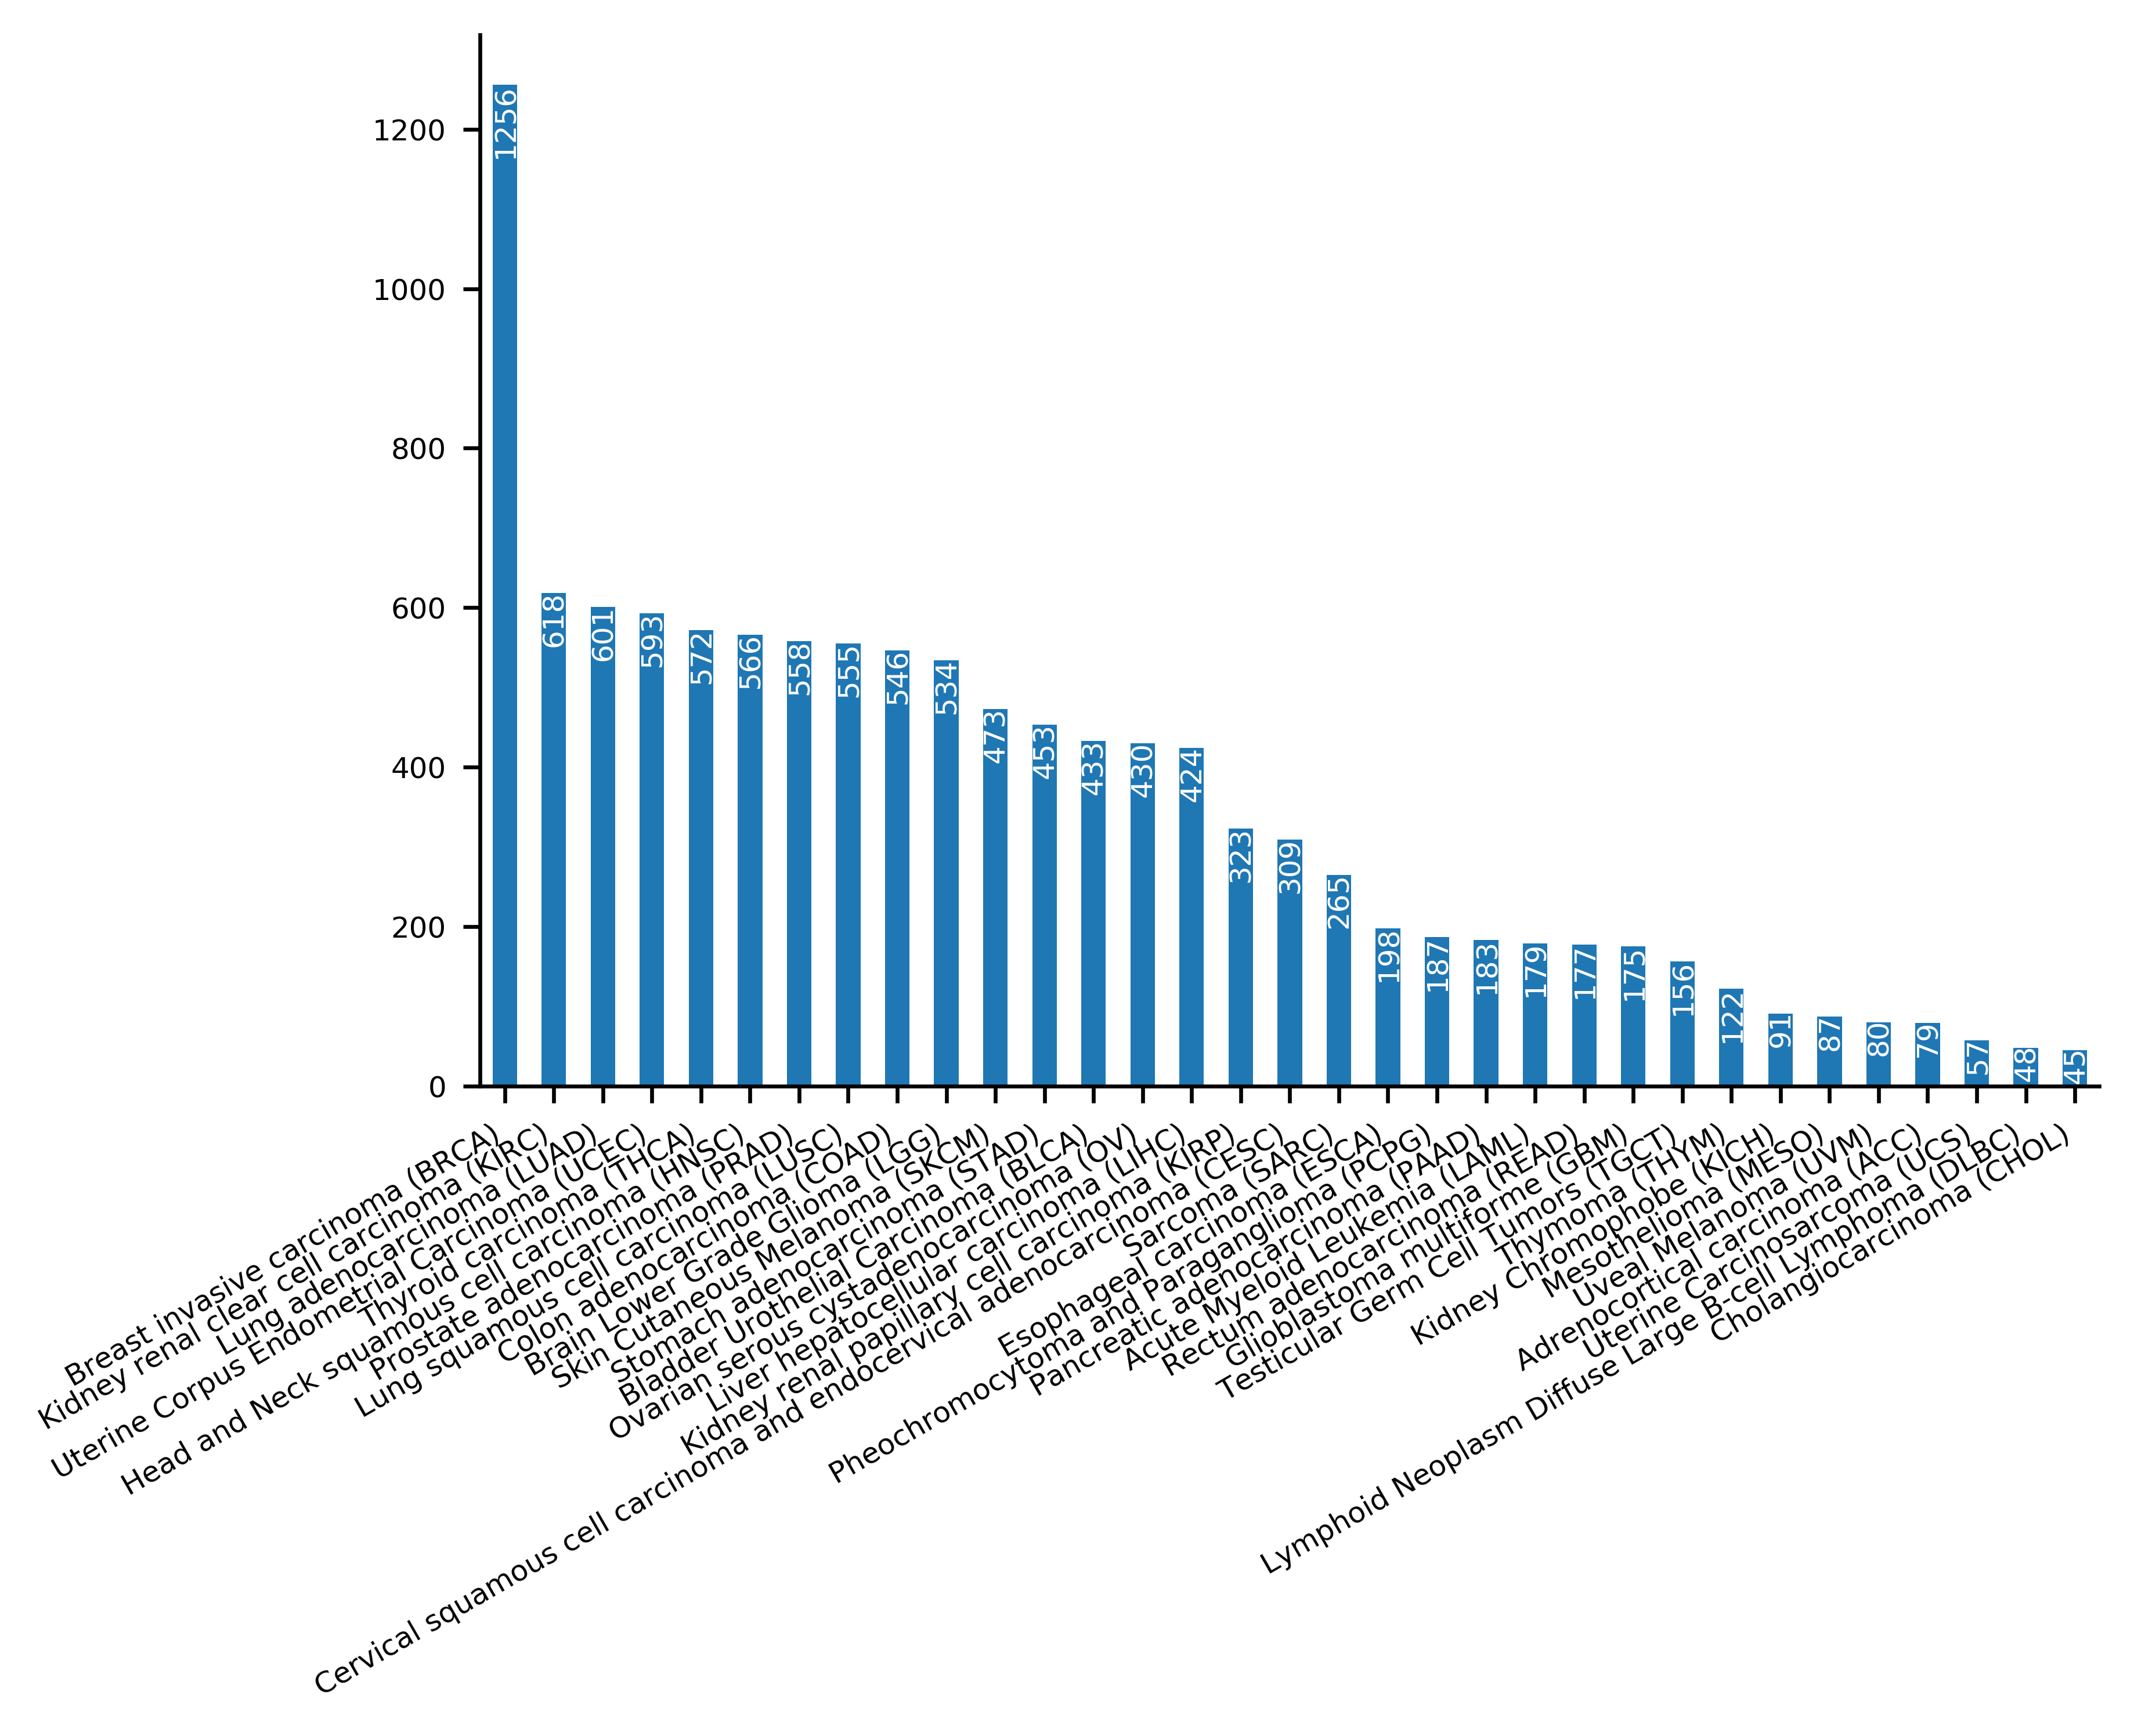

In [186]:
ax = data["CancerType"].apply(tcga_study_abbr_dict2.__getitem__).value_counts().plot(kind='bar')

for i in ax.patches:
    if i.get_height() >= 1:
        ax.text(i.get_x()+0.55, i.get_height() - 25 * len(str(int(round(i.get_height())))) + 15, 
                str(int(round(i.get_height()))), fontsize=6, rotation=90, color='w', ha='right')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.tick_params(axis="y", labelsize=6)

ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=6)

In [ ]:
ax = data["CancerType"].apply(tcga_study_abbr_dict2.__getitem__).value_counts().plot(kind='bar')

pd.DataFrame({'Primary & recurrent tumor': temp.CancerType.apply(tcga_study_abbr_dict2.__getitem__).value_counts(), 
              'Normal & tumor': temp0.CancerType.apply(tcga_study_abbr_dict2.__getitem__).value_counts()}).plot(kind = 'bar', title = 'Number of patients with paired samples')


for i in ax.patches:
    if i.get_height() >= 1:
        ax.text(i.get_x()+0.55, i.get_height() - 25 * len(str(int(round(i.get_height())))) + 15, 
                str(int(round(i.get_height()))), fontsize=6, rotation=90, color='w', ha='right')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.tick_params(axis="y", labelsize=6)

ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=6)

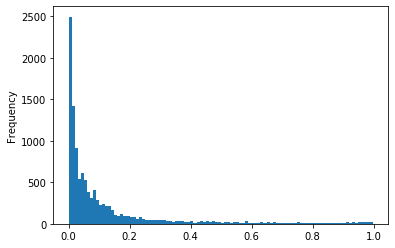

In [6]:
data['P.value'].plot(kind="hist", bins=100)

In [7]:
{'all': data['P.value'].apply(1.00.__ge__).sum(),
'0.05': data['P.value'].apply(0.05.__ge__).sum(),
'0.01': data['P.value'].apply(0.01.__ge__).sum()
}

{'all': 11373, '0.05': 6077, '0.01': 2893}

In [8]:
data['SampleID'].value_counts().where(lambda x: x > 1.0).dropna()

TCGA-A7-A26F-01B-04R-A22O-07    3.0
TCGA-A7-A0DC-01A-11R-A00Z-07    3.0
TCGA-A7-A13G-01B-04R-A22O-07    3.0
TCGA-AC-A2QH-01B-04R-A22O-07    3.0
TCGA-AC-A3OD-01B-06R-A22O-07    3.0
TCGA-A7-A0DC-01B-04R-A22O-07    3.0
TCGA-A7-A26I-01B-06R-A22O-07    3.0
TCGA-A7-A13G-01A-11R-A13Q-07    2.0
TCGA-FI-A2F8-01A-12R-A17B-07    2.0
TCGA-A6-5665-01B-03R-2302-07    2.0
TCGA-CM-4747-01A-01R-1410-07    2.0
TCGA-AK-3454-01A-02R-1277-07    2.0
TCGA-AX-A1C7-01A-11R-A137-07    2.0
TCGA-A6-5661-01B-05R-2302-07    2.0
TCGA-HC-8261-01B-05R-2302-07    2.0
TCGA-HC-7740-01B-04R-2302-07    2.0
TCGA-A7-A26I-01A-11R-A169-07    2.0
TCGA-AA-A01P-01A-21R-A083-07    2.0
TCGA-A7-A0DC-11A-41R-A089-07    2.0
TCGA-A6-2682-01A-01R-1410-07    2.0
TCGA-AZ-4315-01A-01R-1410-07    2.0
TCGA-38-4625-01A-01R-1206-07    2.0
TCGA-AZ-4615-01A-01R-1410-07    2.0
TCGA-AA-A01Z-01A-11R-A083-07    2.0
TCGA-CA-5256-01A-01R-1410-07    2.0
TCGA-AZ-4614-01A-01R-1410-07    2.0
TCGA-AZ-4684-01A-01R-1410-07    2.0
TCGA-AK-3426-01A-02R-1325-07

In [9]:
data[data['SampleID'] == 'TCGA-A7-A0DC-01B-04R-A22O-07']

SampleID CancerType  B.cells.naive  B.cells.memory  \
1762  TCGA-A7-A0DC-01B-04R-A22O-07       BRCA            0.0        0.095566   
1763  TCGA-A7-A0DC-01B-04R-A22O-07       BRCA            0.0        0.113939   
1764  TCGA-A7-A0DC-01B-04R-A22O-07       BRCA            0.0        0.133703   

      Plasma.cells  T.cells.CD8  T.cells.CD4.naive  \
1762      0.045122     0.018111           0.130455   
1763      0.040357     0.005743           0.067493   
1764      0.046857     0.018552           0.031506   

      T.cells.CD4.memory.resting  T.cells.CD4.memory.activated  \
1762                    0.172505                           0.0   
1763                    0.214965                           0.0   
1764                    0.225782                           0.0   

      T.cells.follicular.helper  ...  Macrophages.M2  Dendritic.cells.resting  \
1762                        0.0  ...        0.115555                      0.0   
1763                        0.0  ...        0.125661                      0.0   
1764                        0.0  ...        0.104292                      0.0   

      Dendritic.cells.activated  Mast.cells.resting  Mast.cells.activated  \
1762                   0.067555            0.251592                   0.0   
1763                   0.058962            0.278053                   0.0   
1764                   0.078465            0.211148                   0.0   

      Eosinophils  Neutrophils  P.value  Correlation      RMSE  
1762     0.000000          0.0    0.108     0.099062  1.040622  
1763     0.000000          0.0    0.138     0.078372  1.048953  
1764     0.001334          0.0    0.244     0.045592  1.056600  

[3 rows x 27 columns]

In [10]:
tcga_sample_type_dict = {
    "01": "Primary Solid Tumor",
    "02": "Recurrent Solid Tumor",
    "03": "Primary Blood Derived Cancer - Peripheral Blood",
    "04": "Recurrent Blood Derived Cancer - Bone Marrow",
    "05": "Additional - New Primary",
    "06": "Metastatic",
    "07": "Additional Metastatic",
    "08": "Human Tumor Original Cells",
    "09": "Primary Blood Derived Cancer - Bone Marrow",
    "10": "Blood Derived Normal",
    "11": "Solid Tissue Normal",
    "12": "Buccal Cell Normal",
    "13": "EBV Immortalized Normal",
    "14": "Bone Marrow Normal",
    "15": "sample type 15",
    "16": "sample type 16",
    "20": "Control Analyte",
    "40": "Recurrent Blood Derived Cancer - Peripheral Blood",
    "50": "Cell Lines",
    "60": "Primary Xenograft Tissue",
    "61": "Cell Line Derived Xenograft Tissue",
    "99": "sample type 99"
}

# Basic statistics

In [11]:
f = lambda x: tcga_sample_type_dict[x.split('-')[3][0:2]]
all_data = data.copy()
all_data["SampleType"] = all_data["SampleID"].apply(f)
all_data.groupby(["CancerType", "SampleType"]).SampleID.count().to_frame()

SampleID
CancerType SampleType                     
ACC        Primary Solid Tumor          79
BLCA       Primary Solid Tumor         414
           Solid Tissue Normal          19
BRCA       Metastatic                    7
           Primary Solid Tumor        1135
...                                    ...
UCEC       Primary Solid Tumor         557
           Recurrent Solid Tumor         1
           Solid Tissue Normal          35
UCS        Primary Solid Tumor          57
UVM        Primary Solid Tumor          80

[82 rows x 1 columns]

In [12]:
all_data.SampleType.unique().tolist()

['Primary Solid Tumor',
 'Solid Tissue Normal',
 'Metastatic',
 'Recurrent Solid Tumor',
 'Additional - New Primary',
 'Primary Blood Derived Cancer - Peripheral Blood',
 'Additional Metastatic']

In [13]:
sample_size = pd.crosstab(all_data["CancerType"], all_data["SampleType"])
sample_size.T.style

Index(['ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'DLBC', 'ESCA', 'GBM',
       'HNSC', 'KICH', 'KIRC', 'KIRP', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC',
       'MESO', 'OV', 'PAAD', 'PCPG', 'PRAD', 'READ', 'SARC', 'SKCM', 'STAD',
       'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS', 'UVM'],
      dtype='object', name='CancerType')

(0.0, 1191.75)

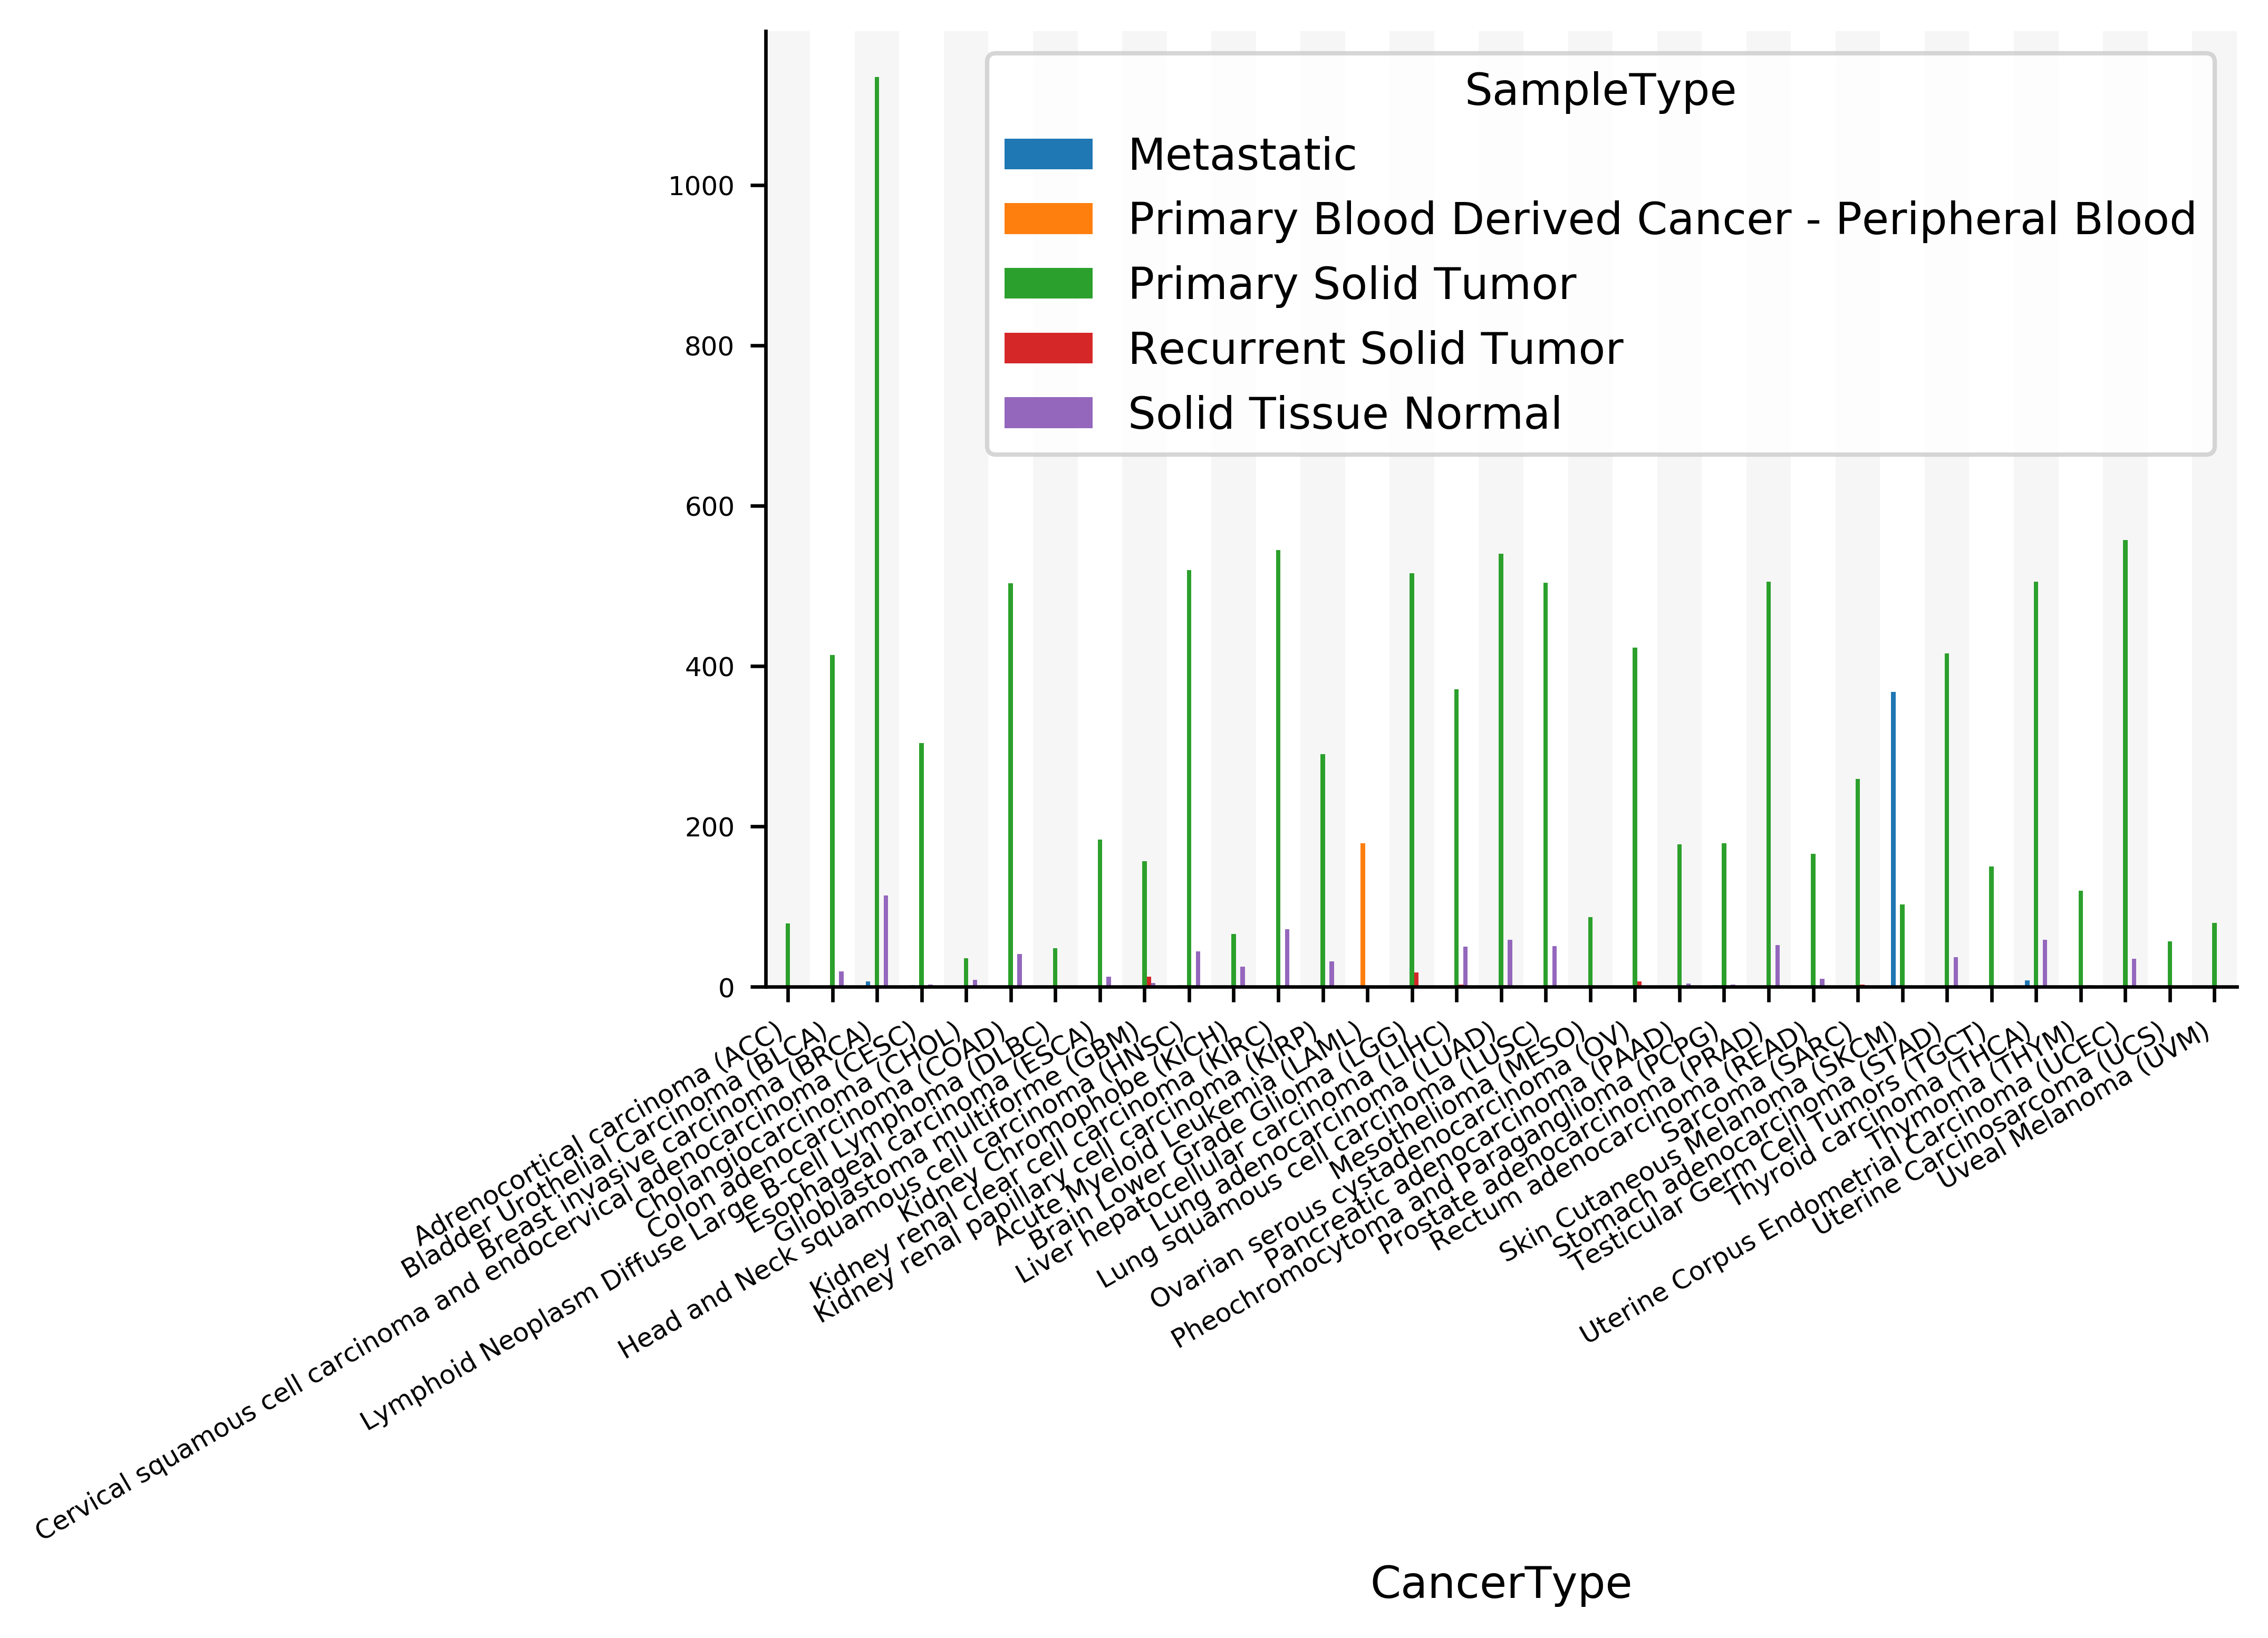

In [219]:
temp = sample_size.copy()
temp.drop('Additional - New Primary', axis = 1, inplace = True)
temp.drop('Additional Metastatic', axis = 1, inplace = True)
temp.index = temp.index.to_series().apply(tcga_study_abbr_dict2.__getitem__)
ax = temp.plot(kind='bar')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.tick_params(axis="y", labelsize=6)

ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=6)

current_ylim = ax.get_ylim()

for i in range(len(sample_size)):
    if i % 2 == 0:
        ax.fill_between([i - 0.5, i + 0.5], current_ylim[0], current_ylim[1], facecolor='lightgray', alpha=0.2)
        
ax.set_ylim(current_ylim)

In [14]:
all_data

SampleID CancerType  B.cells.naive  B.cells.memory  \
0      TCGA-OR-A5JG-01A-11R-A29S-07        ACC       0.000000        0.048529   
1      TCGA-OR-A5LG-01A-11R-A29S-07        ACC       0.007169        0.011125   
2      TCGA-OR-A5JD-01A-11R-A29S-07        ACC       0.000023        0.014607   
3      TCGA-OR-A5LH-01A-11R-A29S-07        ACC       0.047299        0.038180   
4      TCGA-OR-A5KY-01A-11R-A29S-07        ACC       0.000000        0.024795   
...                             ...        ...            ...             ...   
11368  TCGA-V4-A9EQ-01A-11R-A405-07        UVM       0.000000        0.028939   
11369  TCGA-V4-A9EV-01A-11R-A405-07        UVM       0.000000        0.013299   
11370  TCGA-V4-A9EY-01A-11R-A405-07        UVM       0.000000        0.032507   
11371  TCGA-V4-A9EU-01A-11R-A405-07        UVM       0.000000        0.021228   
11372  TCGA-V4-A9EM-01A-11R-A405-07        UVM       0.000000        0.089636   

       Plasma.cells  T.cells.CD8  T.cells.CD4.naive  \
0          0.016052     0.046099           0.027037   
1          0.007982     0.139842           0.000000   
2          0.000000     0.104888           0.000000   
3          0.000000     0.198591           0.000000   
4          0.004418     0.051506           0.000000   
...             ...          ...                ...   
11368      0.008894     0.000000           0.023294   
11369      0.025069     0.315356           0.000000   
11370      0.076160     0.061400           0.034359   
11371      0.010225     0.067985           0.003434   
11372      0.054750     0.059644           0.000000   

       T.cells.CD4.memory.resting  T.cells.CD4.memory.activated  \
0                        0.290682                           0.0   
1                        0.142742                           0.0   
2                        0.174895                           0.0   
3                        0.065240                           0.0   
4                        0.225892                           0.0   
...                           ...                           ...   
11368                    0.015676                           0.0   
11369                    0.017361                           0.0   
11370                    0.000000                           0.0   
11371                    0.006675                           0.0   
11372                    0.039969                           0.0   

       T.cells.follicular.helper  ...  Dendritic.cells.resting  \
0                       0.000000  ...                 0.002715   
1                       0.001614  ...                 0.000000   
2                       0.017928  ...                 0.000000   
3                       0.043310  ...                 0.000000   
4                       0.000000  ...                 0.000000   
...                          ...  ...                      ...   
11368                   0.002279  ...                 0.009128   
11369                   0.095233  ...                 0.015558   
11370                   0.007778  ...                 0.004550   
11371                   0.004884  ...                 0.000000   
11372                   0.005501  ...                 0.000000   

       Dendritic.cells.activated  Mast.cells.resting  Mast.cells.activated  \
0                       0.026125            0.032788              0.000000   
1                       0.007464            0.126237              0.000000   
2                       0.009330            0.000000              0.190730   
3                       0.000576            0.000000              0.064725   
4                       0.042827            0.000000              0.017418   
...                          ...                 ...                   ...   
11368                   0.000000            0.208036              0.000000   
11369                   0.000000            0.061707              0.000000   
11370                   0.000000            0.227797              0.000000   
11371          

In [15]:
cell_types = ['B.cells.naive', 'B.cells.memory', 'Plasma.cells', 'T.cells.CD8',
       'T.cells.CD4.naive', 'T.cells.CD4.memory.resting',
       'T.cells.CD4.memory.activated', 'T.cells.follicular.helper',
       'T.cells.regulatory..Tregs.', 'T.cells.gamma.delta', 'NK.cells.resting',
       'NK.cells.activated', 'Monocytes', 'Macrophages.M0', 'Macrophages.M1',
       'Macrophages.M2', 'Dendritic.cells.resting',
       'Dendritic.cells.activated', 'Mast.cells.resting',
       'Mast.cells.activated', 'Eosinophils', 'Neutrophils']

In [16]:
all_data['Leukocytes.all'] = all_data[cell_types].sum(1)

all_data['T.cells.all'] = all_data[['T.cells.CD8',
                                    'T.cells.CD4.naive',
                                    'T.cells.CD4.memory.resting',
                                    'T.cells.CD4.memory.activated',
                                    'T.cells.follicular.helper',
                                    'T.cells.regulatory..Tregs.',
                                    'T.cells.gamma.delta']].sum(1)

all_data['B.cells.all'] = all_data[['B.cells.naive', 'B.cells.memory']].sum(1)

all_data['Nk.cells.all'] = all_data[['NK.cells.resting', 'NK.cells.activated']].sum(1)

all_data['Macrophages.all'] = all_data[['Macrophages.M0', 'Macrophages.M1', 'Macrophages.M2']].sum(1)

all_data['Dendritic.cells.all'] = all_data[['Dendritic.cells.resting', 'Dendritic.cells.activated']].sum(1)

all_data['Mast.cells.all'] = all_data[['Mast.cells.resting', 'Mast.cells.activated']].sum(1)



augmented_cell_types = cell_types + ['T.cells.all', 'B.cells.all', 'Nk.cells.all', 'Macrophages.all', 
                                     'Dendritic.cells.all', 'Mast.cells.all', 'Leukocytes.all']

## Commons

In [18]:
a = 0.05

num_data = all_data[augmented_cell_types]

sanitize = lambda x: 0.0 if x < 0 else 1.0 if x > 1 else x

for sample_type in sample_size.columns:
    sample_type_mean = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_mean_lower = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_mean_upper = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_sd = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_sd_lower = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_sd_upper = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)

    for j in sample_type_mean.columns:
        n = ((all_data.CancerType == j) & (all_data.SampleType == sample_type)).sum()

        # Mean
        sample_type_mean.loc[:, j] = num_data[(all_data.CancerType == j) & (all_data.SampleType == sample_type)].mean(axis=0)

        # Standard deviation
        sample_type_sd.loc[:, j] = all_data[(all_data.CancerType == j) & (all_data.SampleType == sample_type)].std(ddof=1, axis=0)
        
        # Mean CI
        err = scipy.stats.t.ppf(1 - a / 2, n - 1) * sample_type_sd.loc[:, j] / np.sqrt(n)
        sample_type_mean_lower.loc[:, j] = sample_type_mean.loc[:, j] - err
        sample_type_mean_upper.loc[:, j] = sample_type_mean.loc[:, j] + err
        
        # Standard deviation CI
        sample_type_sd_lower.loc[:, j] = np.sqrt((n - 1) * sample_type_sd.loc[:, j] ** 2 / scipy.stats.chi2.ppf(1 - a / 2, n - 1))
        sample_type_sd_upper.loc[:, j] = np.sqrt((n - 1) * sample_type_sd.loc[:, j] ** 2 / scipy.stats.chi2.ppf(a / 2, n - 1))

    index_str_len = sample_type_mean.index.to_series().apply(lambda x: len(x)).max()
    index_str_len
        
    with pd.ExcelWriter(sample_type + " immune only.xlsx", engine="xlsxwriter") as writer:
        sample_type_mean.to_excel(writer, sheet_name="mean")
        sample_type_mean_lower.applymap(sanitize).to_excel(writer, sheet_name="mean 95% CI lower")
        sample_type_mean_upper.applymap(sanitize).to_excel(writer, sheet_name="mean 95% CI upper")
        
        sample_type_sd.to_excel(writer, sheet_name="sd")
        sample_type_sd_lower.to_excel(writer, sheet_name="sd 95% CI lower")
        sample_type_sd_upper.to_excel(writer, sheet_name="sd 95% CI upper")
        for i in writer.sheets:
            writer.sheets[i].set_column('A:A', index_str_len)

In [20]:
with pd.ExcelWriter("immune only.xlsx", engine="xlsxwriter") as writer:
    sample_size.T.to_excel(writer, sheet_name="summary")

In [201]:
offset_map = {
 'Metastatic': -0.2,
 'Recurrent Solid Tumor': -0.2,
 'Primary Blood Derived Cancer - Peripheral Blood': 0.0,
 'Primary Solid Tumor': 0.0,
 'Solid Tissue Normal': 0.2}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

color_map = {#'Additional - New Primary' : colors[0],
 #'Additional Metastatic': colors[1],
 'Metastatic': colors[0],
 'Primary Blood Derived Cancer - Peripheral Blood': colors[1],
 'Primary Solid Tumor': colors[2],
 'Recurrent Solid Tumor': colors[3],
 'Solid Tissue Normal': colors[4]}

color_map

{'Metastatic': '#1f77b4',
 'Primary Blood Derived Cancer - Peripheral Blood': '#ff7f0e',
 'Primary Solid Tumor': '#2ca02c',
 'Recurrent Solid Tumor': '#d62728',
 'Solid Tissue Normal': '#9467bd'}

In [92]:
cancer_type_map = {v: i for i,v in enumerate(sample_size.index.tolist())}
cancer_type_map

{'ACC': 0,
 'BLCA': 1,
 'BRCA': 2,
 'CESC': 3,
 'CHOL': 4,
 'COAD': 5,
 'DLBC': 6,
 'ESCA': 7,
 'GBM': 8,
 'HNSC': 9,
 'KICH': 10,
 'KIRC': 11,
 'KIRP': 12,
 'LAML': 13,
 'LGG': 14,
 'LIHC': 15,
 'LUAD': 16,
 'LUSC': 17,
 'MESO': 18,
 'OV': 19,
 'PAAD': 20,
 'PCPG': 21,
 'PRAD': 22,
 'READ': 23,
 'SARC': 24,
 'SKCM': 25,
 'STAD': 26,
 'TGCT': 27,
 'THCA': 28,
 'THYM': 29,
 'UCEC': 30,
 'UCS': 31,
 'UVM': 32}

Text(0.5, 1.0, 'T.cells.CD8')

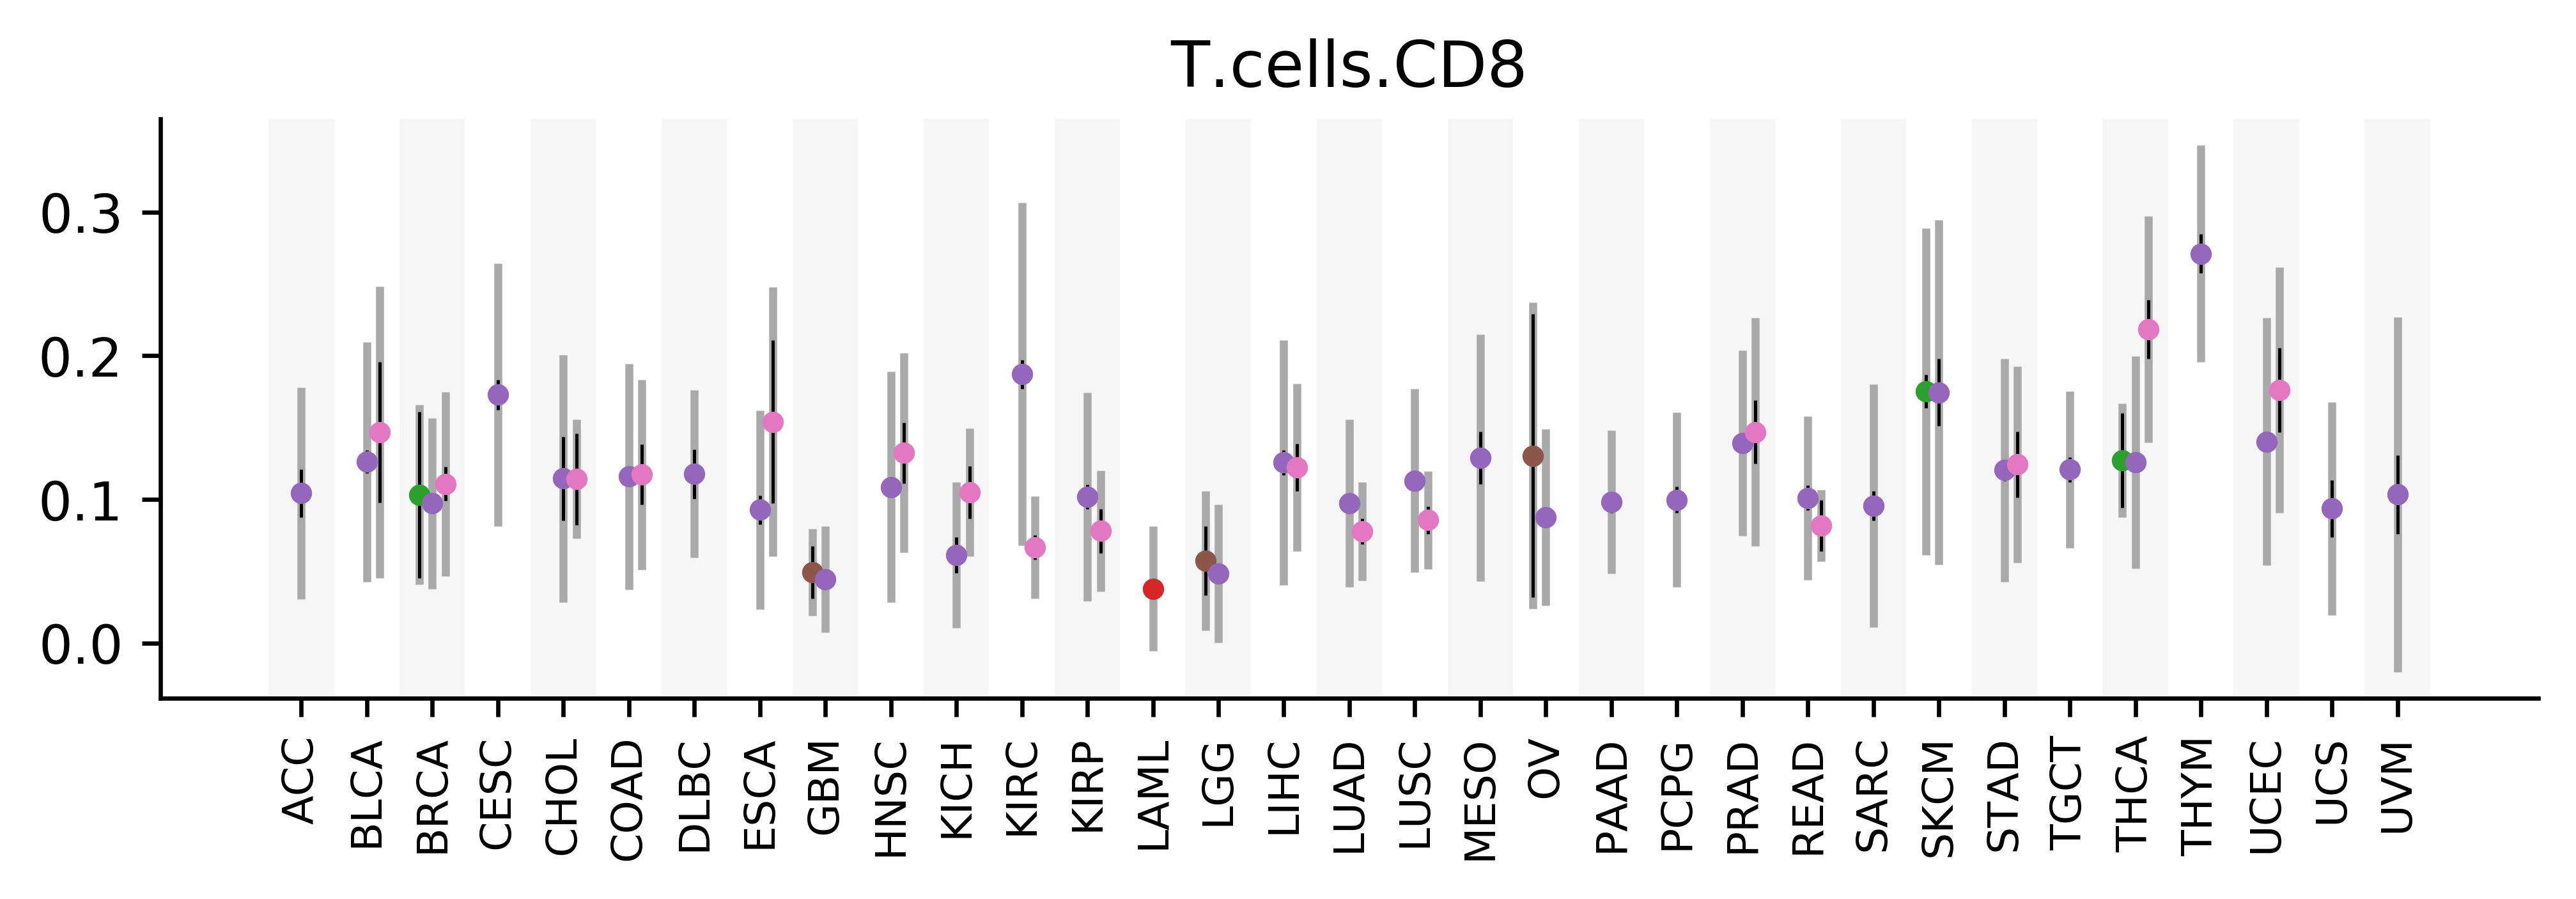

In [124]:
fig = plt.figure(figsize=(8,2))

ax = fig.add_subplot(111)

a = 0.05

num_data = all_data[augmented_cell_types]

sanitize = lambda x: 0.0 if x < 0 else 1.0 if x > 1 else x

cell_type = 'T.cells.CD8'

for sample_type in offset_map:
    sample_type_mean = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_err = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_sd = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)

    for j in sample_type_mean.columns:
        n = ((all_data.CancerType == j) & (all_data.SampleType == sample_type)).sum()
        
        if n > 5:
            # Mean
            sample_type_mean.loc[:, j] = num_data[(all_data.CancerType == j) & (all_data.SampleType == sample_type)].mean(axis=0)

            # Standard deviation
            sample_type_sd.loc[:, j] = all_data[(all_data.CancerType == j) & (all_data.SampleType == sample_type)].std(ddof=1, axis=0)

            # Mean CI
            sample_type_err.loc[:, j] = scipy.stats.t.ppf(1 - a / 2, n - 1) * sample_type_sd.loc[:, j] / np.sqrt(n)
        
    x = [cancer_type_map[cancer_type] + offset_map[sample_type] for cancer_type in cancer_type_map]
    y = [sample_type_mean.loc[cell_type, cancer_type] for cancer_type in cancer_type_map]
    yerr = [[sample_type_err.loc[cell_type, cancer_type] for cancer_type in cancer_type_map], 
            [sample_type_sd.loc[cell_type, cancer_type] for cancer_type in cancer_type_map]]
    
    ax.errorbar(x, y, yerr=yerr[1], fmt='.', color = color_map[sample_type], ecolor = 'darkgray', elinewidth=1.5)
    ax.errorbar(x, y, yerr=yerr[0], fmt="None", color = color_map[sample_type], ecolor = 'black', elinewidth=0.6)
    
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


current_ylim = ax.get_ylim()
#plt.vlines([i + 0.5 for i in list(cancer_type_map.values())[:-1]], ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1], 
#           color = 'lightgray', linestyles = 'dashed', linewidth=0.5)

for i in list(cancer_type_map.values()):
    if i % 2 == 0:
        ax.fill_between([i - 0.5, i + 0.5], ax.get_ylim()[0], ax.get_ylim()[1], facecolor='lightgray', alpha=0.2)

ax.set_ylim(current_ylim)
ax.set_xlim(-0.5, len(cancer_type_map) - 0.5)
# Ticks
plt.xticks(list(cancer_type_map.values()), list(cancer_type_map.keys()), rotation=90, fontsize=8)
plt.title(cell_type)

Text(0.5, 1.0, 'Plasma.cells')

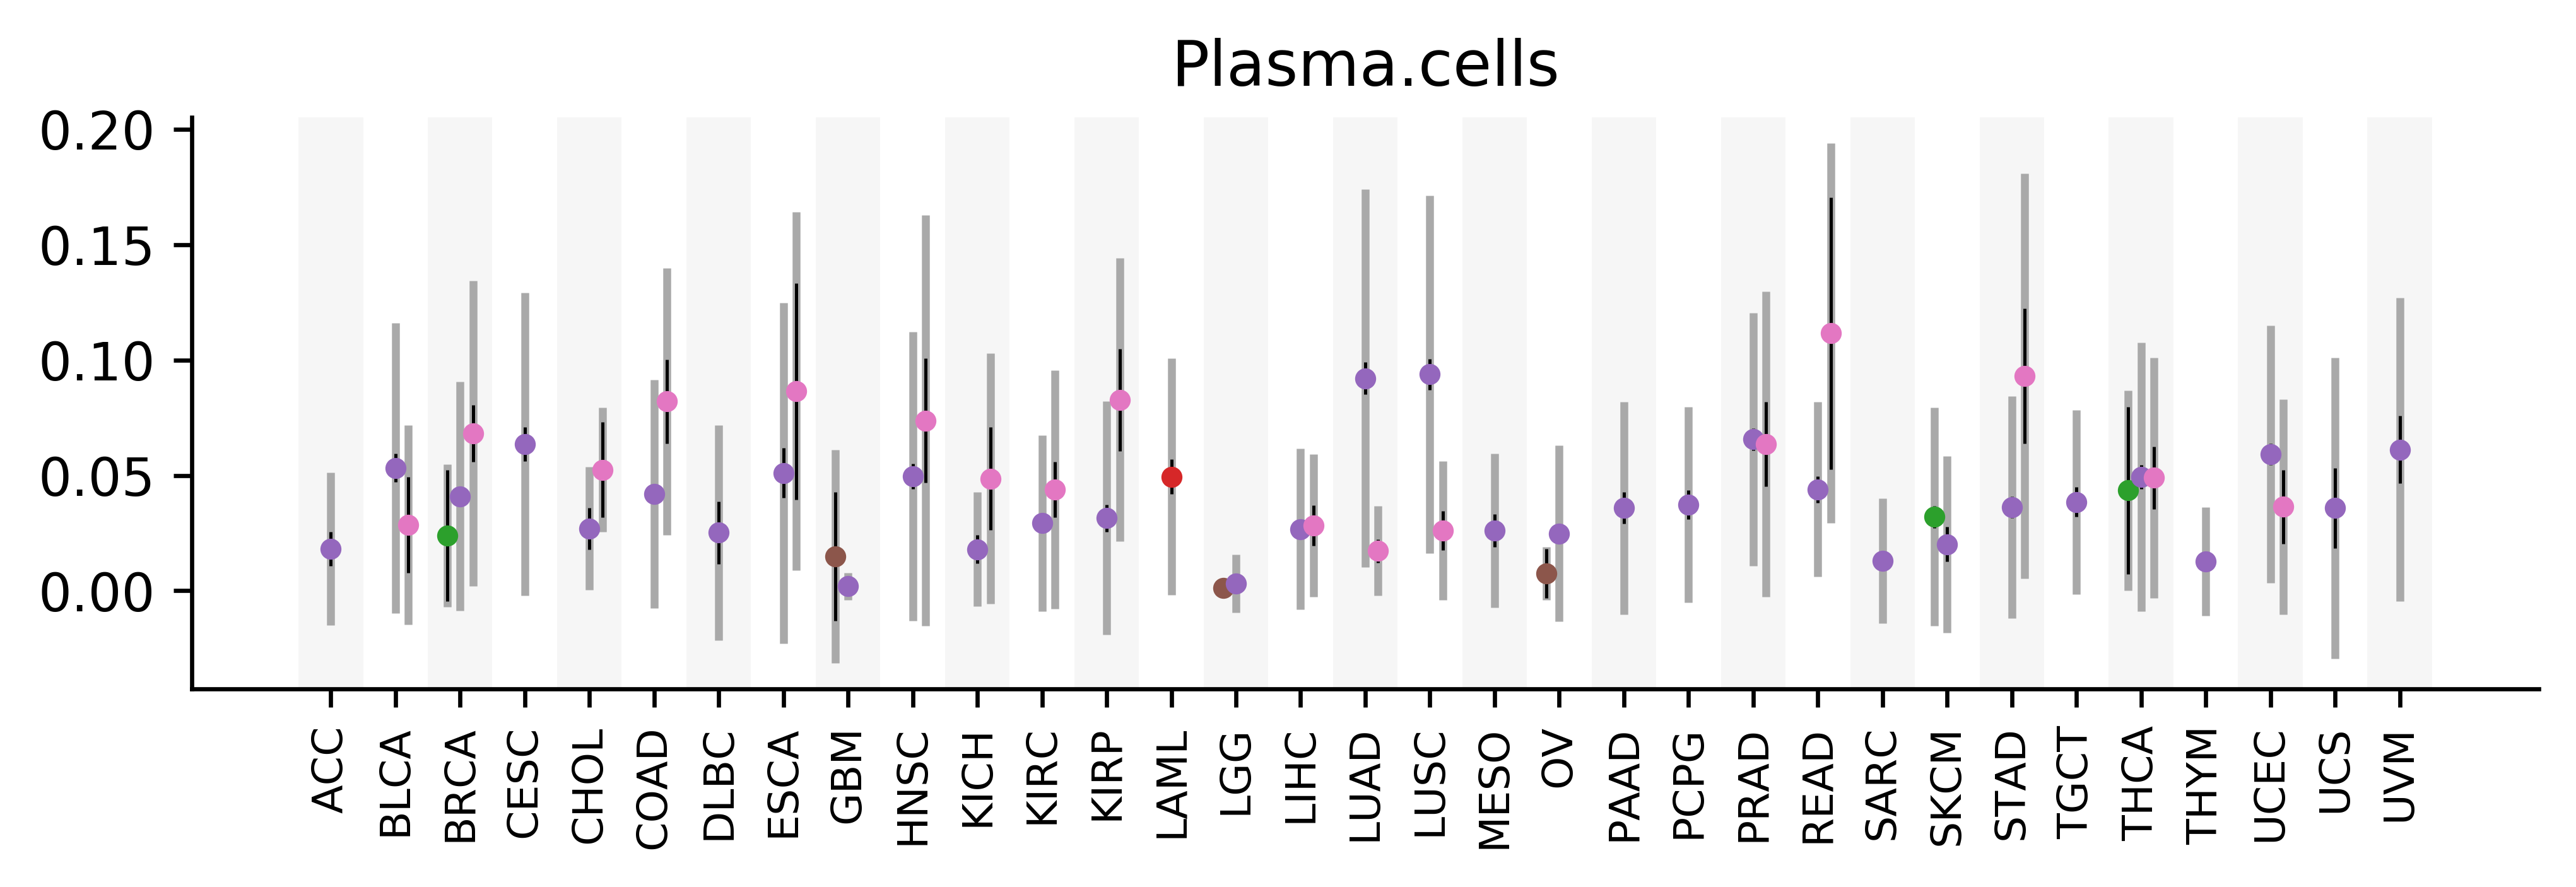

In [123]:
fig = plt.figure(figsize=(8,2))

ax = fig.add_subplot(111)

num_data = all_data[augmented_cell_types]

sanitize = lambda x: 0.0 if x < 0 else 1.0 if x > 1 else x

cell_type = 'Plasma.cells'

for sample_type in offset_map:
    sample_type_mean = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_err = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
    sample_type_sd = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)

    for j in sample_type_mean.columns:
        n = ((all_data.CancerType == j) & (all_data.SampleType == sample_type)).sum()
        
        if n > 5:
            # Mean
            sample_type_mean.loc[:, j] = num_data[(all_data.CancerType == j) & (all_data.SampleType == sample_type)].mean(axis=0)

            # Standard deviation
            sample_type_sd.loc[:, j] = all_data[(all_data.CancerType == j) & (all_data.SampleType == sample_type)].std(ddof=1, axis=0)

            # Mean CI
            sample_type_err.loc[:, j] = scipy.stats.t.ppf(1 - a / 2, n - 1) * sample_type_sd.loc[:, j] / np.sqrt(n)
        
    x = [cancer_type_map[cancer_type] + offset_map[sample_type] for cancer_type in cancer_type_map]
    y = [sample_type_mean.loc[cell_type, cancer_type] for cancer_type in cancer_type_map]
    yerr = [[sample_type_err.loc[cell_type, cancer_type] for cancer_type in cancer_type_map], 
            [sample_type_sd.loc[cell_type, cancer_type] for cancer_type in cancer_type_map]]
    
    ax.errorbar(x, y, yerr=yerr[1], fmt='.', color = color_map[sample_type], ecolor = 'darkgray', elinewidth=1.5)
    ax.errorbar(x, y, yerr=yerr[0], fmt="None", color = color_map[sample_type], ecolor = 'black', elinewidth=0.6)
    
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


current_ylim = ax.get_ylim()
#plt.vlines([i + 0.5 for i in list(cancer_type_map.values())[:-1]], ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1], 
#           color = 'lightgray', linestyles = 'dashed', linewidth=0.5)

for i in list(cancer_type_map.values()):
    if i % 2 == 0:
        ax.fill_between([i - 0.5, i + 0.5], current_ylim[0], current_ylim[1], facecolor='lightgray', alpha=0.2)

ax.set_ylim(current_ylim)

# Ticks
plt.xticks(list(cancer_type_map.values()), list(cancer_type_map.keys()), rotation=90, fontsize=8)
plt.title(cell_type)

In [179]:
augmented_cell_types

['B.cells.naive',
 'B.cells.memory',
 'Plasma.cells',
 'T.cells.CD8',
 'T.cells.CD4.naive',
 'T.cells.CD4.memory.resting',
 'T.cells.CD4.memory.activated',
 'T.cells.follicular.helper',
 'T.cells.regulatory..Tregs.',
 'T.cells.gamma.delta',
 'NK.cells.resting',
 'NK.cells.activated',
 'Monocytes',
 'Macrophages.M0',
 'Macrophages.M1',
 'Macrophages.M2',
 'Dendritic.cells.resting',
 'Dendritic.cells.activated',
 'Mast.cells.resting',
 'Mast.cells.activated',
 'Eosinophils',
 'Neutrophils',
 'T.cells.all',
 'B.cells.all',
 'Nk.cells.all',
 'Macrophages.all',
 'Dendritic.cells.all',
 'Mast.cells.all',
 'Leukocytes.all']

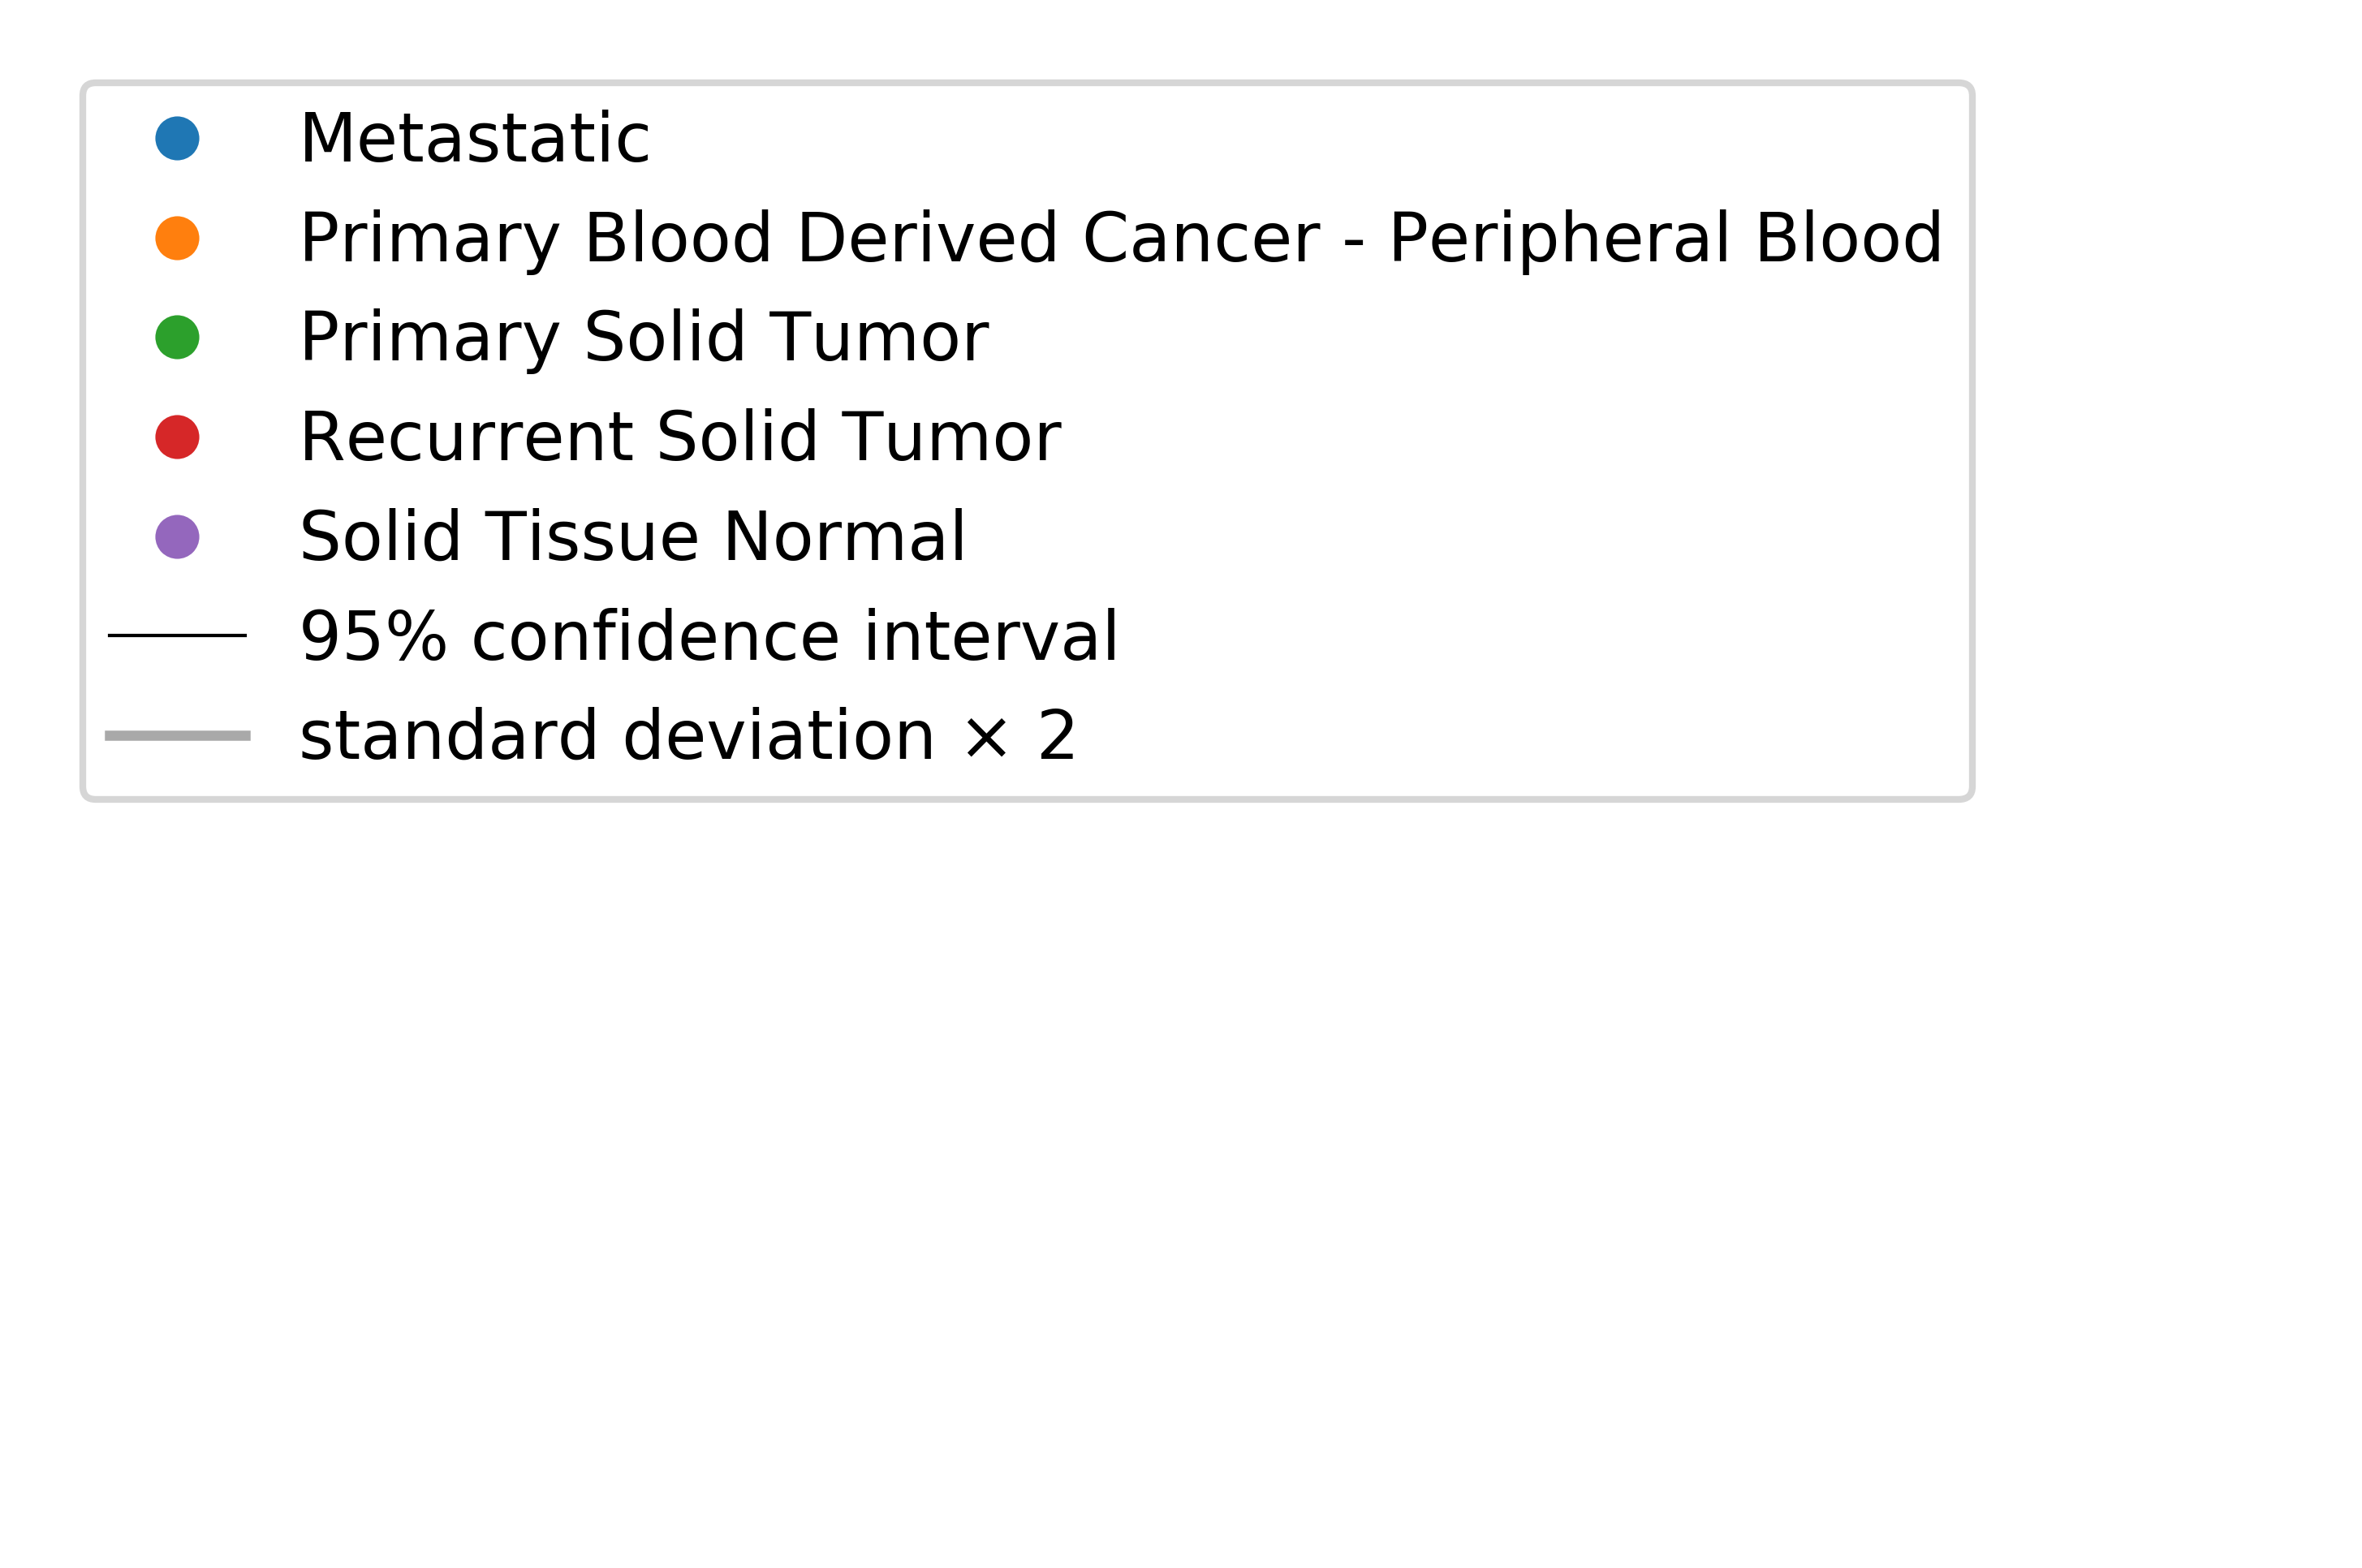

In [203]:
legend_elements = [mpl.lines.Line2D([0], [0], marker='.', color='w', markerfacecolor=color_map[i], label=i, markersize=15) 
                   for i in color_map]

legend_elements.append(mpl.lines.Line2D([0], [0], marker='None', color='black', label='95% confidence interval', linewidth=0.5))
legend_elements.append(mpl.lines.Line2D([0], [0], marker='None', color='darkgray', label='standard deviation × 2', linewidth=1.5))

# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='upper left')

ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

[Text(0, 0, 'ACC'),
 Text(0, 0, 'BLCA'),
 Text(0, 0, 'BRCA'),
 Text(0, 0, 'CESC'),
 Text(0, 0, 'CHOL'),
 Text(0, 0, 'COAD'),
 Text(0, 0, 'DLBC'),
 Text(0, 0, 'ESCA'),
 Text(0, 0, 'GBM'),
 Text(0, 0, 'HNSC'),
 Text(0, 0, 'KICH'),
 Text(0, 0, 'KIRC'),
 Text(0, 0, 'KIRP'),
 Text(0, 0, 'LAML'),
 Text(0, 0, 'LGG'),
 Text(0, 0, 'LIHC'),
 Text(0, 0, 'LUAD'),
 Text(0, 0, 'LUSC'),
 Text(0, 0, 'MESO'),
 Text(0, 0, 'OV'),
 Text(0, 0, 'PAAD'),
 Text(0, 0, 'PCPG'),
 Text(0, 0, 'PRAD'),
 Text(0, 0, 'READ'),
 Text(0, 0, 'SARC'),
 Text(0, 0, 'SKCM'),
 Text(0, 0, 'STAD'),
 Text(0, 0, 'TGCT'),
 Text(0, 0, 'THCA'),
 Text(0, 0, 'THYM'),
 Text(0, 0, 'UCEC'),
 Text(0, 0, 'UCS'),
 Text(0, 0, 'UVM')]

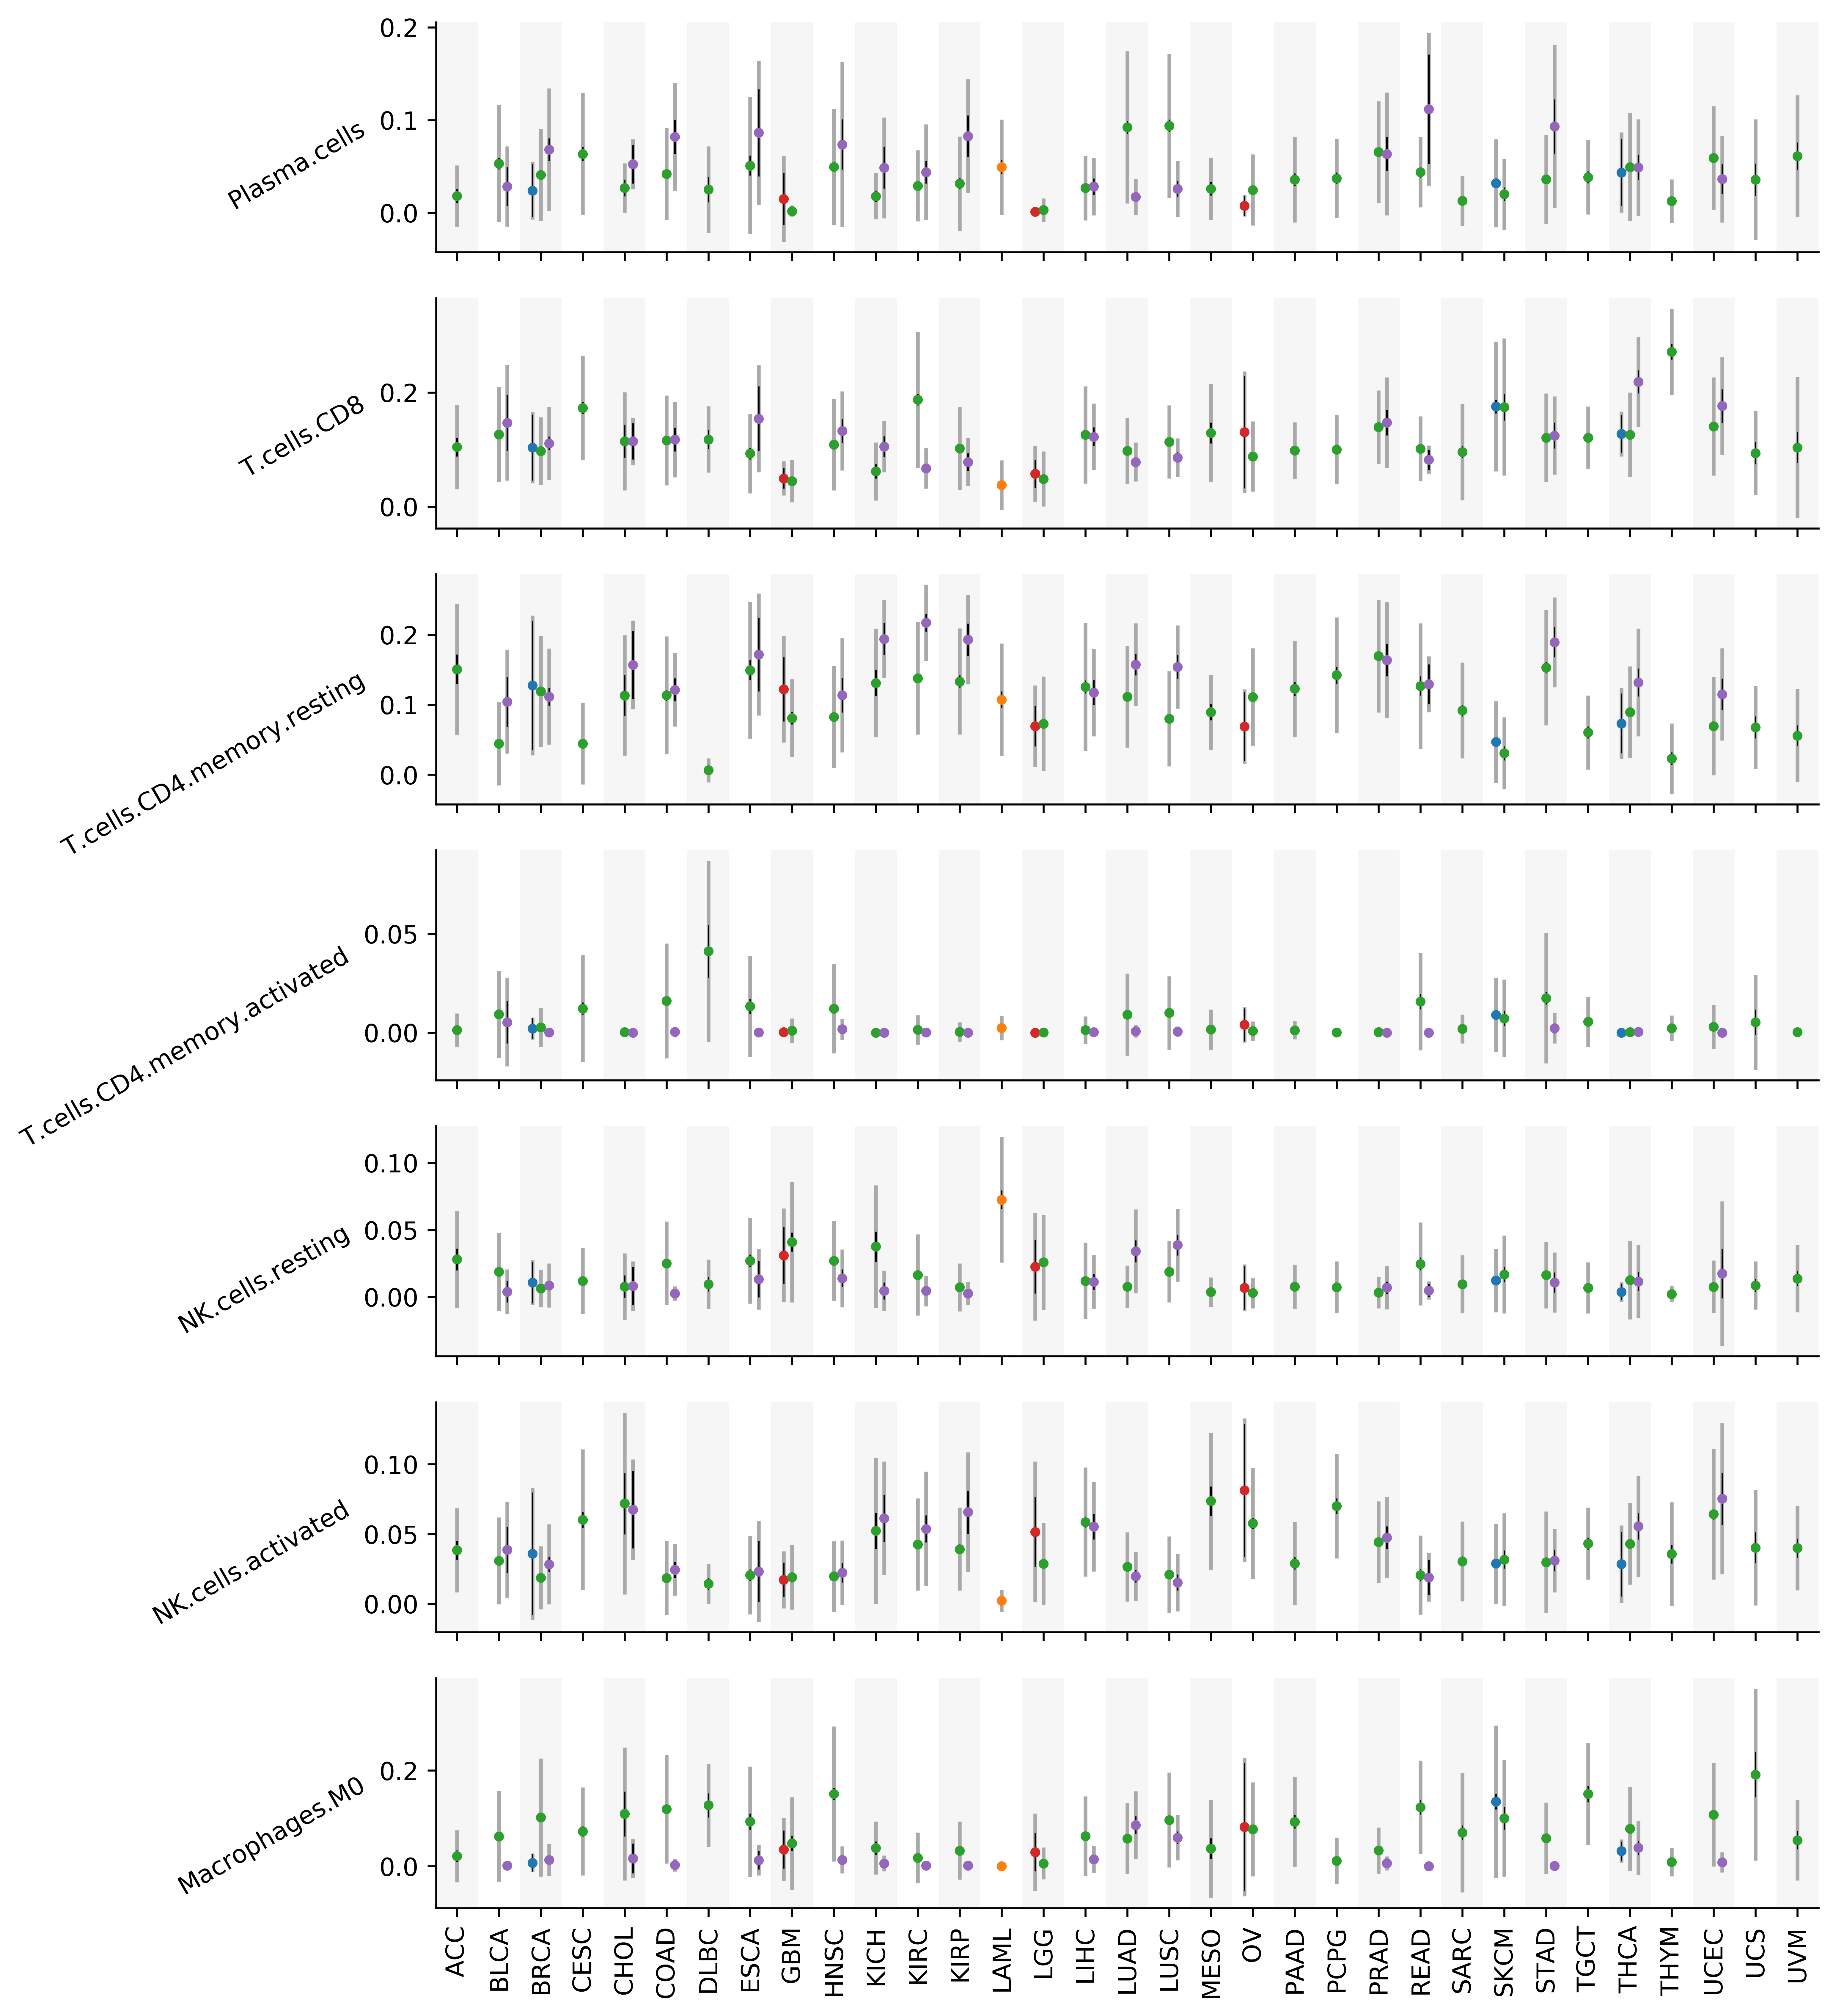

In [220]:
plot_cell_types = [
 'Plasma.cells',
 'T.cells.CD8',
 'T.cells.CD4.memory.resting',
 'T.cells.CD4.memory.activated',
 'NK.cells.resting',
 'NK.cells.activated',
 'Macrophages.M0']

fig = plt.figure(figsize=(10, 2 * len(plot_cell_types)))

plot_cell_types_map = {v: i for i, v in enumerate(plot_cell_types)}

axes = []

a = 0.05

num_data = all_data[augmented_cell_types]

sanitize = lambda x: 0.0 if x < 0 else 1.0 if x > 1 else x

for cell_type in plot_cell_types:
    if len(axes) == 0:
        ax = fig.add_subplot(len(plot_cell_types), 1, 1)
    else:
        ax = fig.add_subplot(len(plot_cell_types), 1, len(axes) + 1, sharex = axes[0])
    
    axes.append(ax)
    
    for sample_type in offset_map:
        sample_type_mean = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
        sample_type_err = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
        sample_type_sd = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)

        for j in sample_type_mean.columns:
            n = ((all_data.CancerType == j) & (all_data.SampleType == sample_type)).sum()

            if n > 5:
                # Mean
                sample_type_mean.loc[:, j] = num_data[(all_data.CancerType == j) & (all_data.SampleType == sample_type)].mean(axis=0)

                # Standard deviation
                sample_type_sd.loc[:, j] = all_data[(all_data.CancerType == j) & (all_data.SampleType == sample_type)].std(ddof=1, axis=0)

                # Mean CI
                sample_type_err.loc[:, j] = scipy.stats.t.ppf(1 - a / 2, n - 1) * sample_type_sd.loc[:, j] / np.sqrt(n)

        x = [cancer_type_map[cancer_type] + offset_map[sample_type] for cancer_type in cancer_type_map]
        y = [sample_type_mean.loc[cell_type, cancer_type] for cancer_type in cancer_type_map]
        yerr = [[sample_type_err.loc[cell_type, cancer_type] for cancer_type in cancer_type_map], 
                [sample_type_sd.loc[cell_type, cancer_type] for cancer_type in cancer_type_map]]

        ax.errorbar(x, y, yerr=yerr[1], fmt='.', color = color_map[sample_type], ecolor = 'darkgray', elinewidth=1.5)
        ax.errorbar(x, y, yerr=yerr[0], fmt="None", color = color_map[sample_type], ecolor = 'black', elinewidth=0.6)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')


    current_ylim = ax.get_ylim()
    for i in list(cancer_type_map.values()):
        if i % 2 == 0:
            ax.fill_between([i - 0.5, i + 0.5], current_ylim[0], current_ylim[1], facecolor='lightgray', alpha=0.2)

    ax.set_ylim(current_ylim)
    ax.set_xticks(list(cancer_type_map.values()))
    ax.tick_params(axis='x', which = 'both', labelbottom=None)
    ax.set_ylabel(cell_type, rotation = 30, ha = 'right')
    ax.set_xlim(-0.5, len(cancer_type_map) - 0.5)
    
# Ticks
ax.tick_params(axis='x', which = 'both', labelbottom=True)
ax.set_xticks(list(cancer_type_map.values()))
ax.set_xticklabels(list(cancer_type_map.keys()), rotation=90)

[Text(0, 0, 'ACC'),
 Text(0, 0, 'BLCA'),
 Text(0, 0, 'BRCA'),
 Text(0, 0, 'CESC'),
 Text(0, 0, 'CHOL'),
 Text(0, 0, 'COAD'),
 Text(0, 0, 'DLBC'),
 Text(0, 0, 'ESCA'),
 Text(0, 0, 'GBM'),
 Text(0, 0, 'HNSC'),
 Text(0, 0, 'KICH'),
 Text(0, 0, 'KIRC'),
 Text(0, 0, 'KIRP'),
 Text(0, 0, 'LAML'),
 Text(0, 0, 'LGG'),
 Text(0, 0, 'LIHC'),
 Text(0, 0, 'LUAD'),
 Text(0, 0, 'LUSC'),
 Text(0, 0, 'MESO'),
 Text(0, 0, 'OV'),
 Text(0, 0, 'PAAD'),
 Text(0, 0, 'PCPG'),
 Text(0, 0, 'PRAD'),
 Text(0, 0, 'READ'),
 Text(0, 0, 'SARC'),
 Text(0, 0, 'SKCM'),
 Text(0, 0, 'STAD'),
 Text(0, 0, 'TGCT'),
 Text(0, 0, 'THCA'),
 Text(0, 0, 'THYM'),
 Text(0, 0, 'UCEC'),
 Text(0, 0, 'UCS'),
 Text(0, 0, 'UVM')]

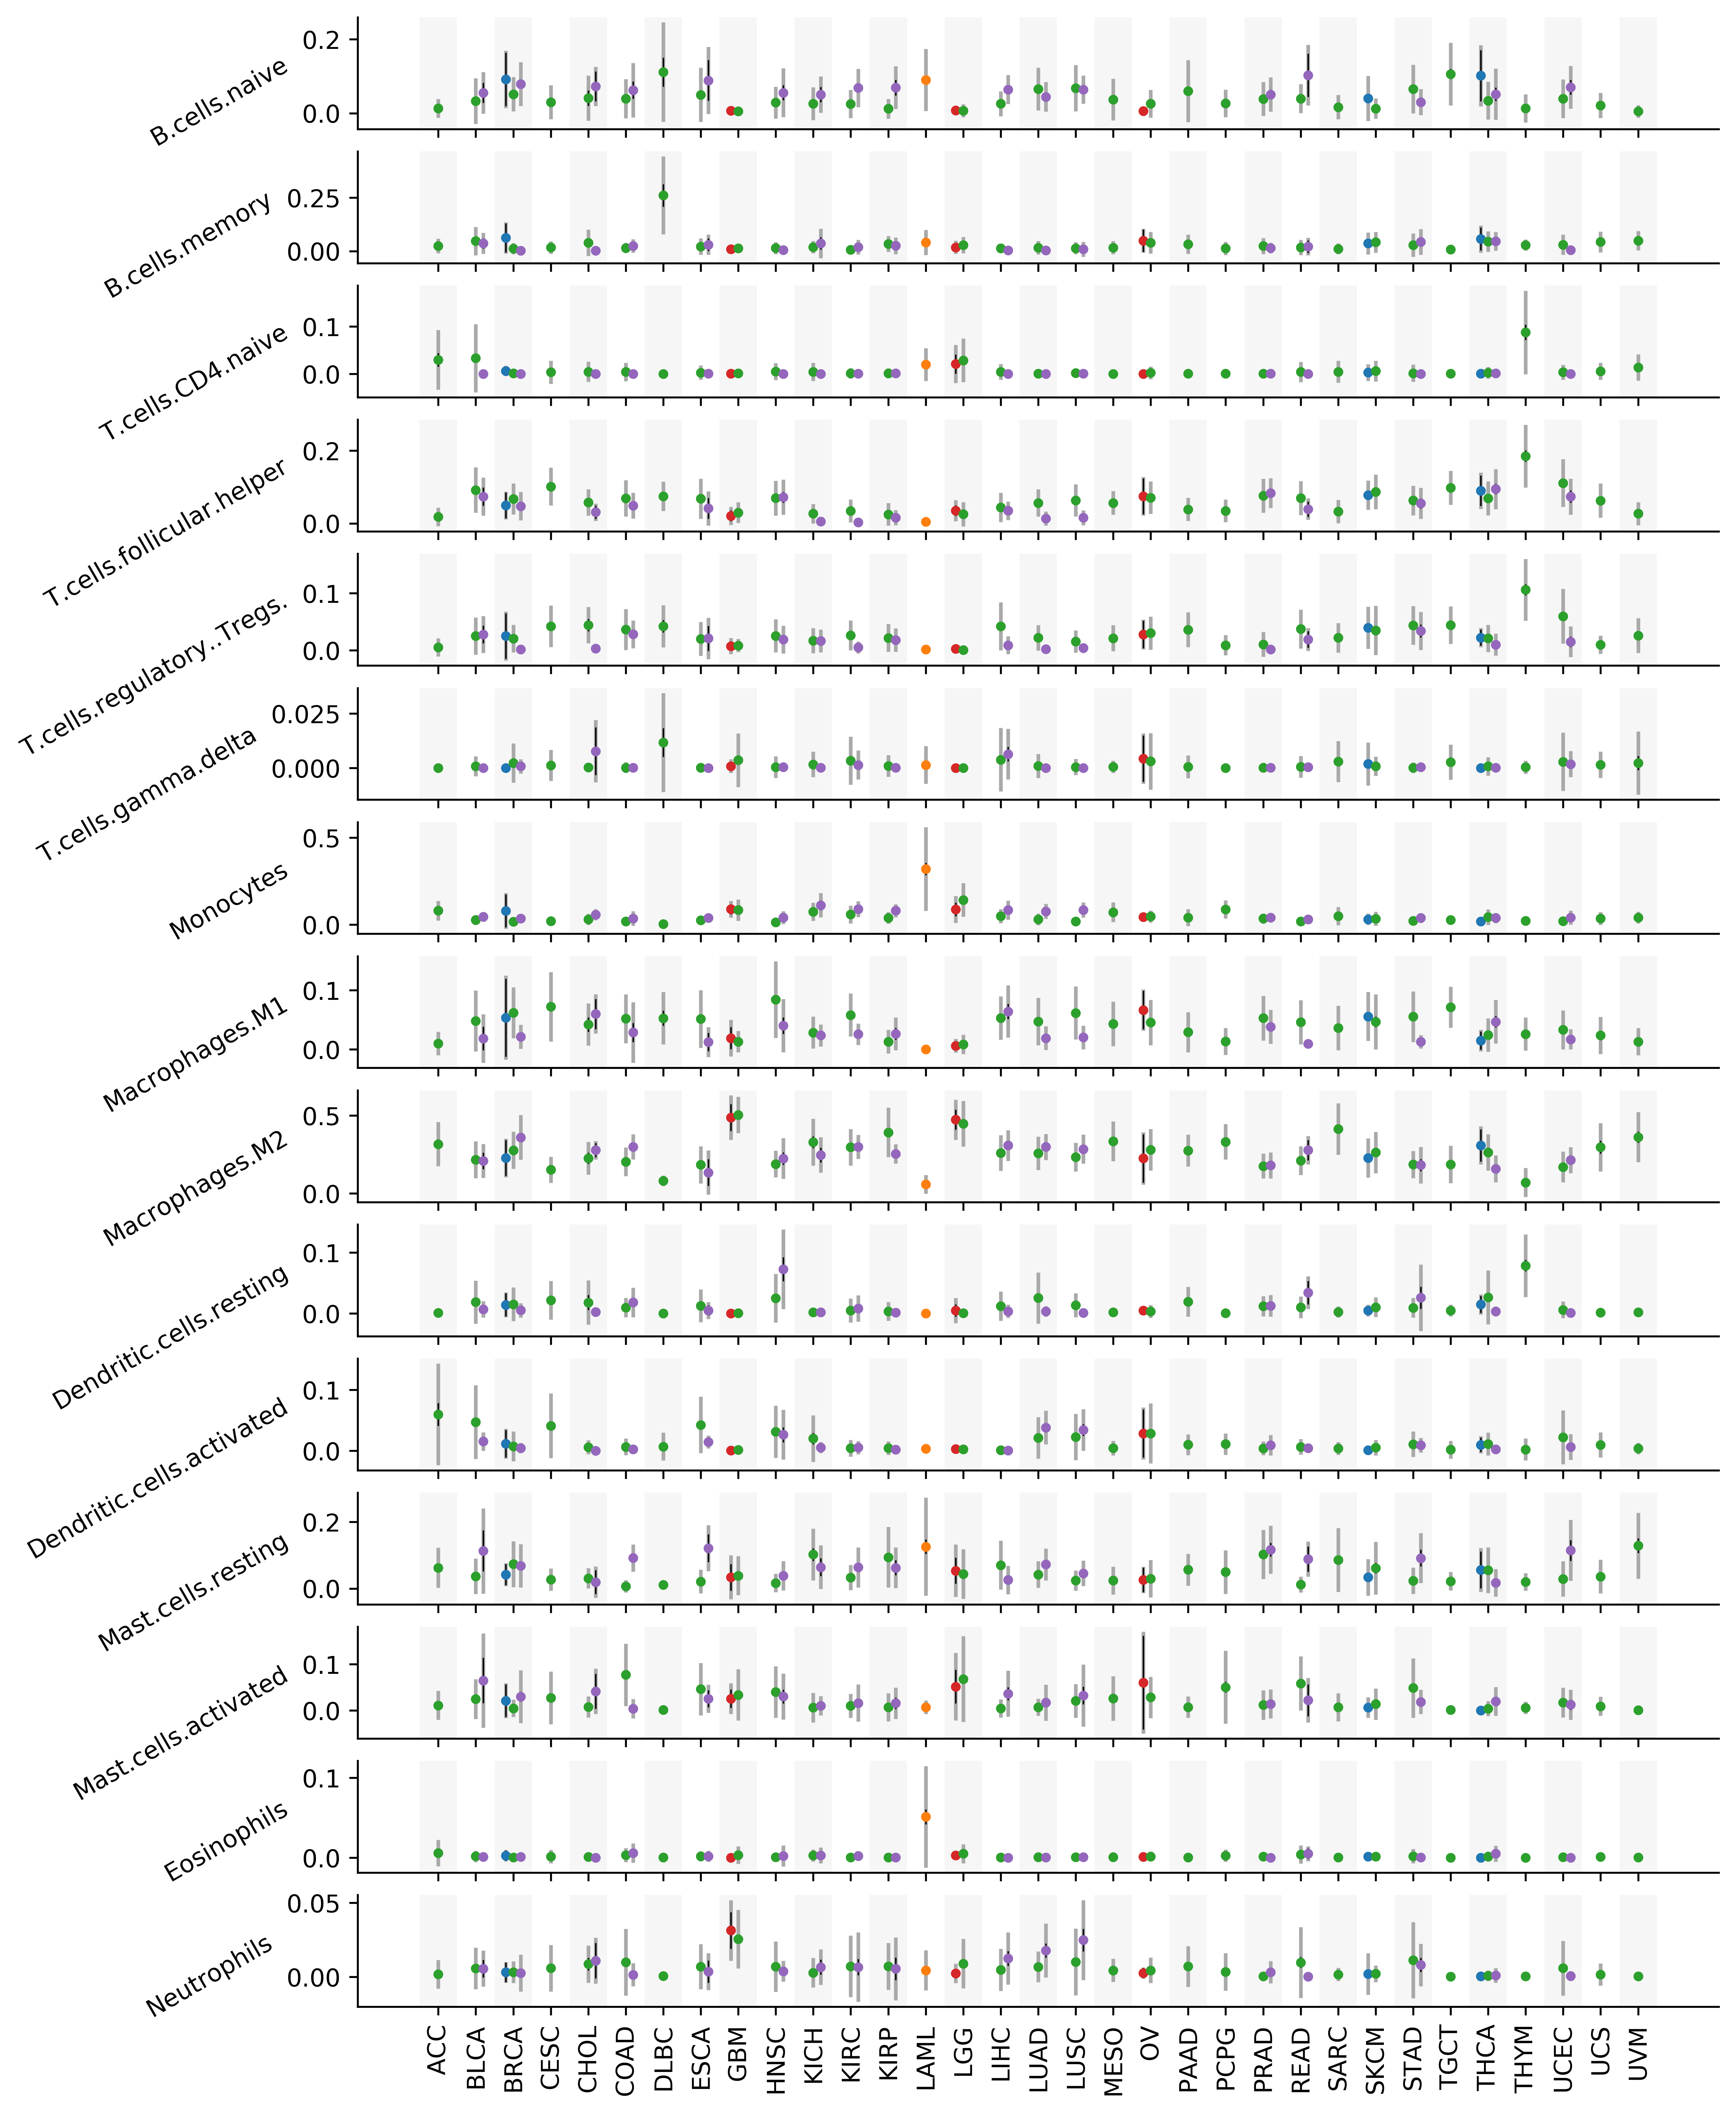

In [214]:
plot_cell_types = ['B.cells.naive',
 'B.cells.memory',
 'T.cells.CD4.naive',
 'T.cells.follicular.helper',
 'T.cells.regulatory..Tregs.',
 'T.cells.gamma.delta',
 'Monocytes',
 'Macrophages.M1',
 'Macrophages.M2',
 'Dendritic.cells.resting',
 'Dendritic.cells.activated',
 'Mast.cells.resting',
 'Mast.cells.activated',
 'Eosinophils',
 'Neutrophils']

fig = plt.figure(figsize=(10, 1 * len(plot_cell_types)))

plot_cell_types_map = {v: i for i, v in enumerate(plot_cell_types)}

axes = []

a = 0.05

num_data = all_data[augmented_cell_types]

sanitize = lambda x: 0.0 if x < 0 else 1.0 if x > 1 else x

for cell_type in plot_cell_types:
    if len(axes) == 0:
        ax = fig.add_subplot(len(plot_cell_types), 1, 1)
    else:
        ax = fig.add_subplot(len(plot_cell_types), 1, len(axes) + 1, sharex = axes[0])
    
    axes.append(ax)
    
    for sample_type in offset_map:
        sample_type_mean = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
        sample_type_err = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
        sample_type_sd = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)

        for j in sample_type_mean.columns:
            n = ((all_data.CancerType == j) & (all_data.SampleType == sample_type)).sum()

            if n > 5:
                # Mean
                sample_type_mean.loc[:, j] = num_data[(all_data.CancerType == j) & (all_data.SampleType == sample_type)].mean(axis=0)

                # Standard deviation
                sample_type_sd.loc[:, j] = all_data[(all_data.CancerType == j) & (all_data.SampleType == sample_type)].std(ddof=1, axis=0)

                # Mean CI
                sample_type_err.loc[:, j] = scipy.stats.t.ppf(1 - a / 2, n - 1) * sample_type_sd.loc[:, j] / np.sqrt(n)

        x = [cancer_type_map[cancer_type] + offset_map[sample_type] for cancer_type in cancer_type_map]
        y = [sample_type_mean.loc[cell_type, cancer_type] for cancer_type in cancer_type_map]
        yerr = [[sample_type_err.loc[cell_type, cancer_type] for cancer_type in cancer_type_map], 
                [sample_type_sd.loc[cell_type, cancer_type] for cancer_type in cancer_type_map]]

        ax.errorbar(x, y, yerr=yerr[1], fmt='.', color = color_map[sample_type], ecolor = 'darkgray', elinewidth=1.5)
        ax.errorbar(x, y, yerr=yerr[0], fmt="None", color = color_map[sample_type], ecolor = 'black', elinewidth=0.6)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')


    current_ylim = ax.get_ylim()
    for i in list(cancer_type_map.values()):
        if i % 2 == 0:
            ax.fill_between([i - 0.5, i + 0.5], current_ylim[0], current_ylim[1], facecolor='lightgray', alpha=0.2)

    ax.set_ylim(current_ylim)
    ax.set_xticks(list(cancer_type_map.values()))
    ax.tick_params(axis='x', which = 'both', labelbottom=None)
    ax.set_ylabel(cell_type, rotation = 30, ha = 'right')
    ax.set_xlim(-0.5, len(cancer_type_map) - 0.5)
    
# Ticks
ax.tick_params(axis='x', which = 'both', labelbottom=True)
ax.set_xticks(list(cancer_type_map.values()))
ax.set_xticklabels(list(cancer_type_map.keys()), rotation=90)

[Text(0, 0, 'ACC'),
 Text(0, 0, 'BLCA'),
 Text(0, 0, 'BRCA'),
 Text(0, 0, 'CESC'),
 Text(0, 0, 'CHOL'),
 Text(0, 0, 'COAD'),
 Text(0, 0, 'DLBC'),
 Text(0, 0, 'ESCA'),
 Text(0, 0, 'GBM'),
 Text(0, 0, 'HNSC'),
 Text(0, 0, 'KICH'),
 Text(0, 0, 'KIRC'),
 Text(0, 0, 'KIRP'),
 Text(0, 0, 'LAML'),
 Text(0, 0, 'LGG'),
 Text(0, 0, 'LIHC'),
 Text(0, 0, 'LUAD'),
 Text(0, 0, 'LUSC'),
 Text(0, 0, 'MESO'),
 Text(0, 0, 'OV'),
 Text(0, 0, 'PAAD'),
 Text(0, 0, 'PCPG'),
 Text(0, 0, 'PRAD'),
 Text(0, 0, 'READ'),
 Text(0, 0, 'SARC'),
 Text(0, 0, 'SKCM'),
 Text(0, 0, 'STAD'),
 Text(0, 0, 'TGCT'),
 Text(0, 0, 'THCA'),
 Text(0, 0, 'THYM'),
 Text(0, 0, 'UCEC'),
 Text(0, 0, 'UCS'),
 Text(0, 0, 'UVM')]

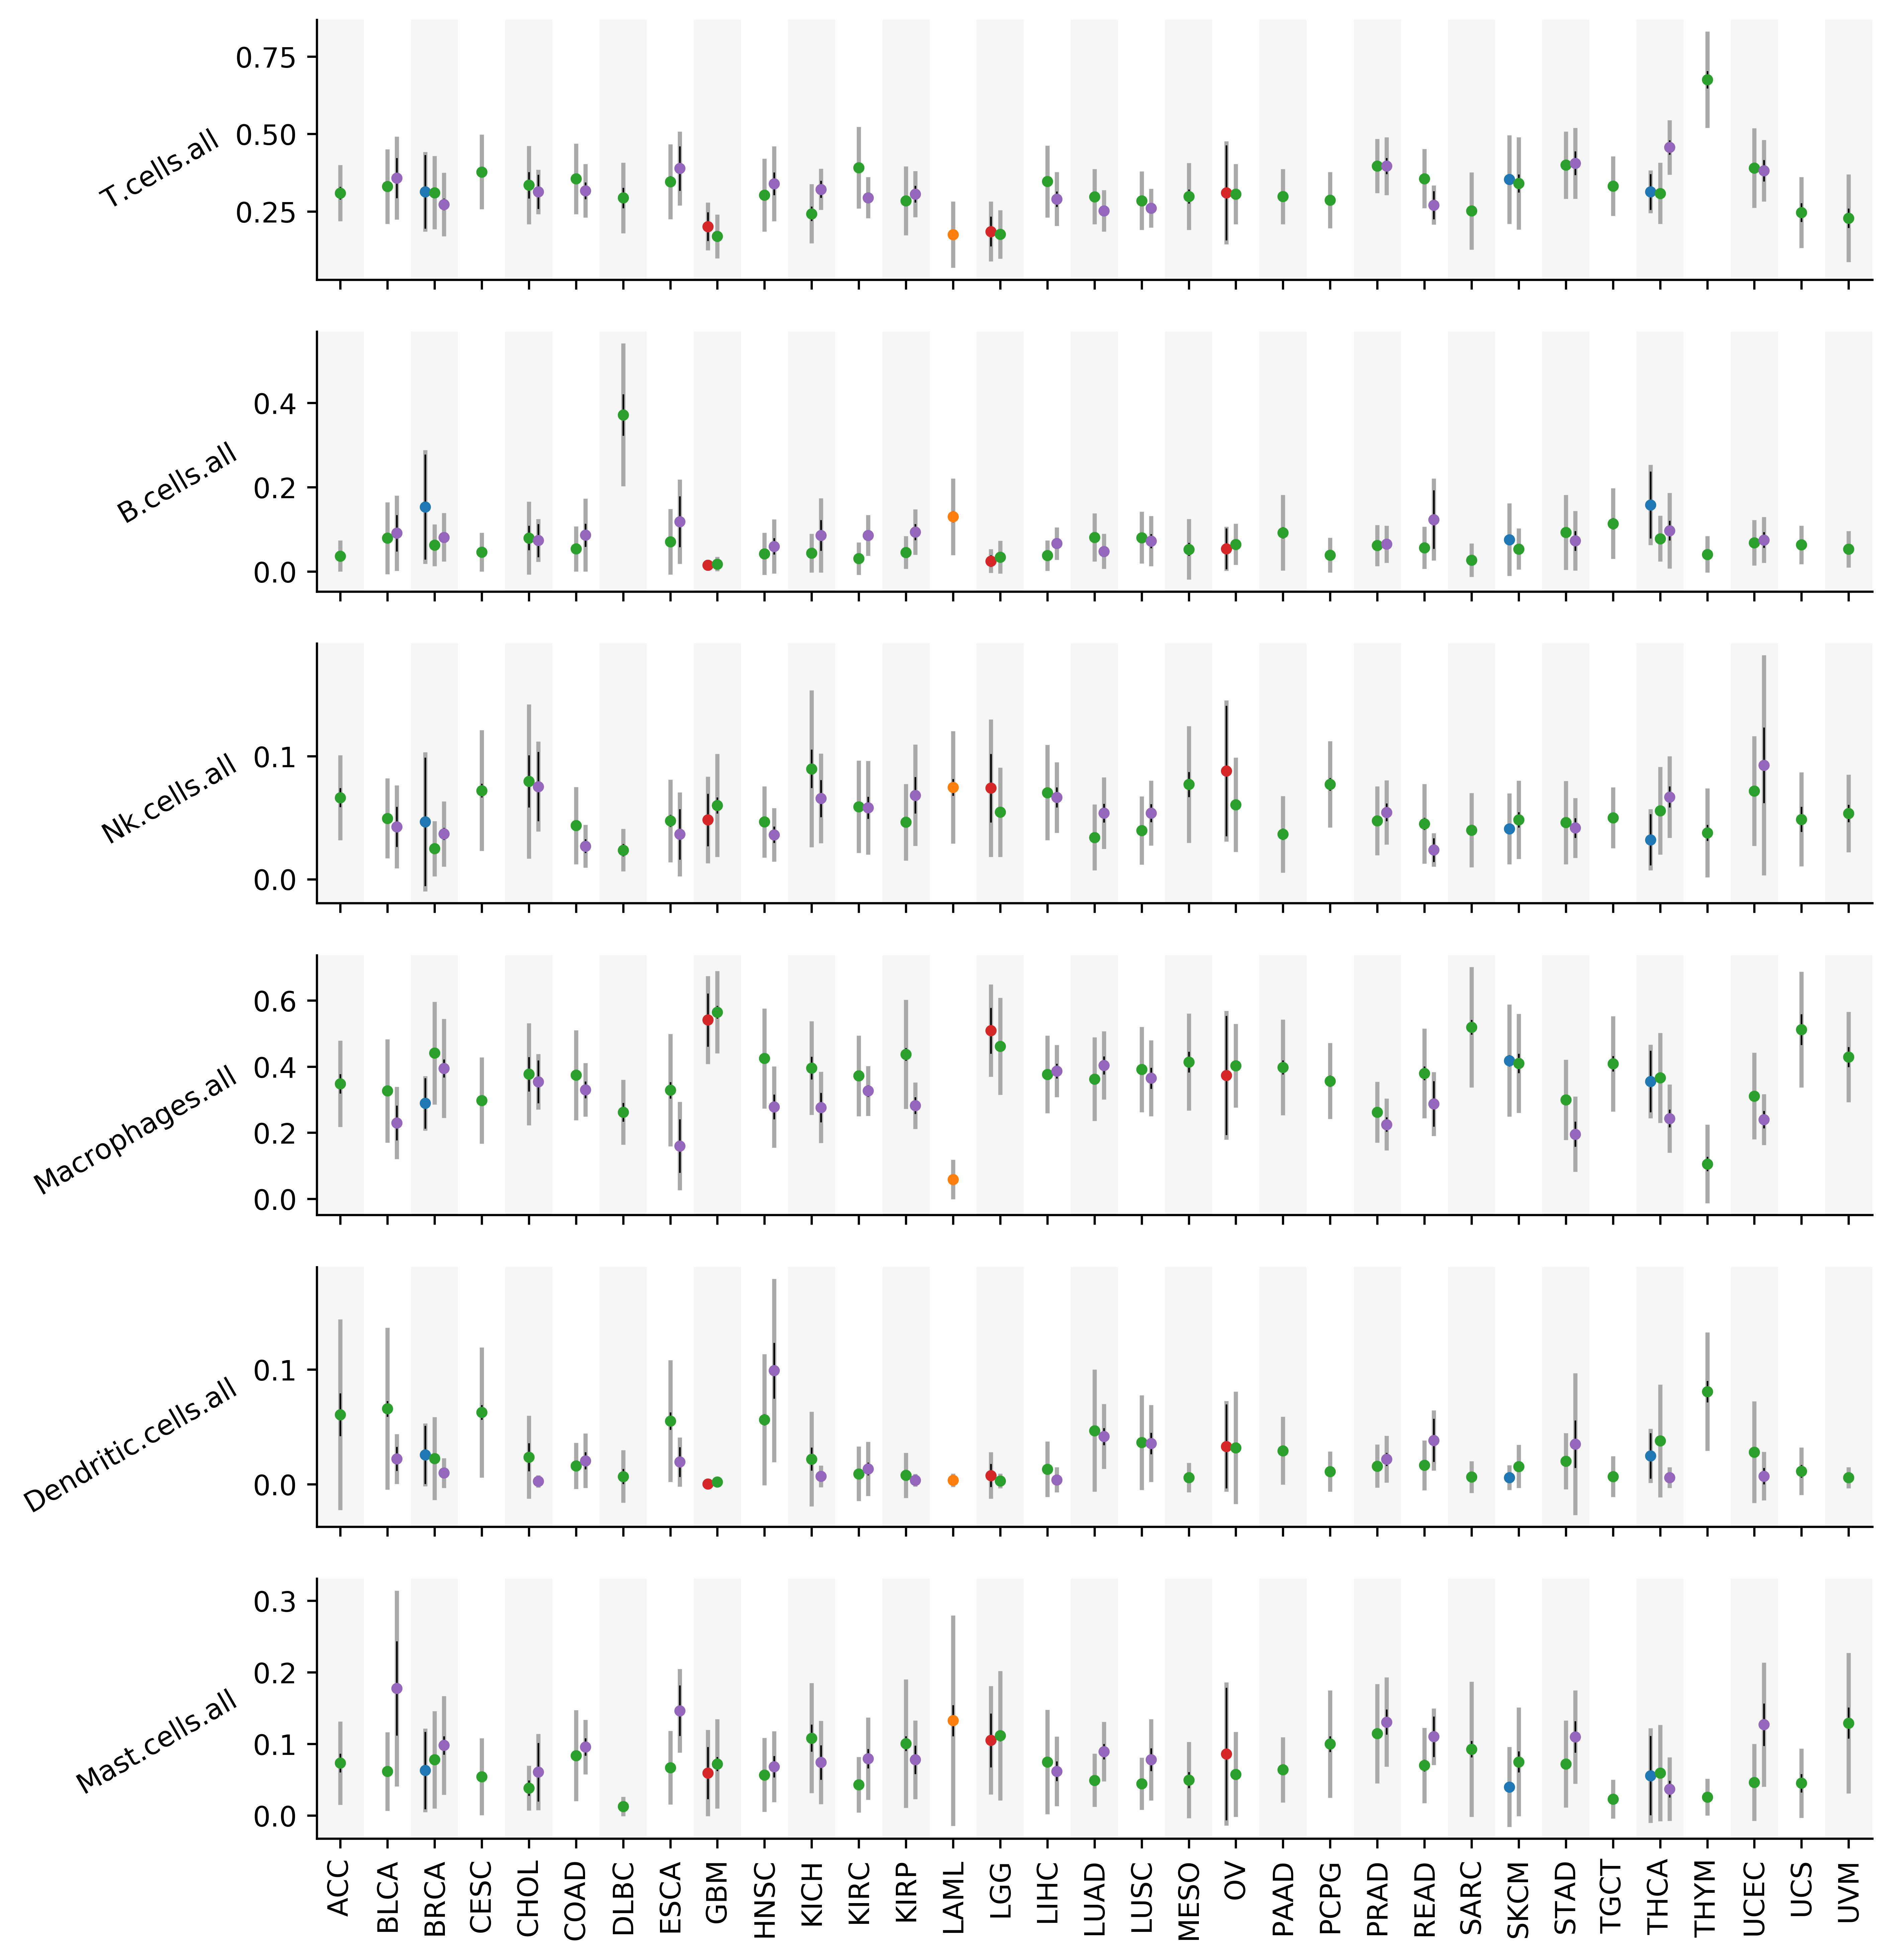

In [218]:
plot_cell_types = ['T.cells.all', 'B.cells.all', 'Nk.cells.all', 'Macrophages.all', 
                                     'Dendritic.cells.all', 'Mast.cells.all']

fig = plt.figure(figsize=(10, 2 * len(plot_cell_types)))

plot_cell_types_map = {v: i for i, v in enumerate(plot_cell_types)}

axes = []

a = 0.05

num_data = all_data[augmented_cell_types]

sanitize = lambda x: 0.0 if x < 0 else 1.0 if x > 1 else x

for cell_type in plot_cell_types:
    if len(axes) == 0:
        ax = fig.add_subplot(len(plot_cell_types), 1, 1)
    else:
        ax = fig.add_subplot(len(plot_cell_types), 1, len(axes) + 1, sharex = axes[0])
    
    axes.append(ax)
    
    for sample_type in offset_map:
        sample_type_mean = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
        sample_type_err = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)
        sample_type_sd = pd.DataFrame(index = augmented_cell_types, columns = sample_size.index)

        for j in sample_type_mean.columns:
            n = ((all_data.CancerType == j) & (all_data.SampleType == sample_type)).sum()

            if n > 5:
                # Mean
                sample_type_mean.loc[:, j] = num_data[(all_data.CancerType == j) & (all_data.SampleType == sample_type)].mean(axis=0)

                # Standard deviation
                sample_type_sd.loc[:, j] = all_data[(all_data.CancerType == j) & (all_data.SampleType == sample_type)].std(ddof=1, axis=0)

                # Mean CI
                sample_type_err.loc[:, j] = scipy.stats.t.ppf(1 - a / 2, n - 1) * sample_type_sd.loc[:, j] / np.sqrt(n)

        x = [cancer_type_map[cancer_type] + offset_map[sample_type] for cancer_type in cancer_type_map]
        y = [sample_type_mean.loc[cell_type, cancer_type] for cancer_type in cancer_type_map]
        yerr = [[sample_type_err.loc[cell_type, cancer_type] for cancer_type in cancer_type_map], 
                [sample_type_sd.loc[cell_type, cancer_type] for cancer_type in cancer_type_map]]

        ax.errorbar(x, y, yerr=yerr[1], fmt='.', color = color_map[sample_type], ecolor = 'darkgray', elinewidth=1.5)
        ax.errorbar(x, y, yerr=yerr[0], fmt="None", color = color_map[sample_type], ecolor = 'black', elinewidth=0.6)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')


    current_ylim = ax.get_ylim()
    for i in list(cancer_type_map.values()):
        if i % 2 == 0:
            ax.fill_between([i - 0.5, i + 0.5], current_ylim[0], current_ylim[1], facecolor='lightgray', alpha=0.2)

    ax.set_ylim(current_ylim)
    ax.set_xlim(-0.5, len(cancer_type_map) - 0.5)
    ax.set_xticks(list(cancer_type_map.values()))
    ax.tick_params(axis='x', which = 'both', labelbottom=None)
    ax.set_ylabel(cell_type, rotation = 30, ha = 'right')

# Ticks
ax.tick_params(axis='x', which = 'both', labelbottom=True)
ax.set_xticks(list(cancer_type_map.values()))
ax.set_xticklabels(list(cancer_type_map.keys()), rotation=90)

In [80]:
ax.get_ylim()

(-0.17732657616355693, 0.5763440078646308)

In [66]:
list(cancer_type_map.values())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32]